In [ ]:
!pip install bds_courseware

In [ ]:
!pip install -U seaborn

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.0)


In [ ]:
!pip install --upgrade pandas_profiling --user

Requirement already up-to-date: pandas_profiling in /root/.local/lib/python3.6/site-packages (2.9.0)


In [ ]:
!pip install impyute

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas_profiling
from google.colab import drive
from urllib.request import urlopen
%matplotlib inline
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, Normalizer
from sklearn.manifold import TSNE
import umap
from bds_courseware import get_dataset
from bds_courseware.__ids import __datasets 
from bds_courseware._utils import _read_drive_data as read_data
from google.colab import drive
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, precision_score, f1_score, recall_score
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet, SGDClassifier
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
SEED=42

#Auxilarity methods

In [ ]:
def linreg_scores(data):
  target1 = data['Target'].values
  train_X, val_X, train_y, val_y = train_test_split(data.drop(['Time','Target'], axis=1), target1, 
                                                    random_state=SEED, shuffle=False, test_size = 0.2)
  linreg = LinearRegression()
  linreg.fit(train_X, train_y)
  predictions = linreg.predict(val_X)

  r2 = metrics.r2_score(val_y, predictions)
  rmse = np.sqrt(metrics.mean_squared_error(val_y, predictions))

  return np.array(predictions), pd.DataFrame.from_dict({'R2':r2, 'RMSE':rmse}, orient='index', columns=['Score'])

In [ ]:
def linreg_scores_without_time(data):
  target1 = data['Target'].values
  train_X, val_X, train_y, val_y = train_test_split(data.drop(['Target'], axis=1), target1, 
                                                    random_state=SEED, shuffle=False, test_size = 0.2)
  linreg = LinearRegression()
  linreg.fit(train_X, train_y)
  predictions = linreg.predict(val_X)

  r2 = metrics.r2_score(val_y, predictions)
  rmse = np.sqrt(metrics.mean_squared_error(val_y, predictions))

  return np.array(predictions), pd.DataFrame.from_dict({'R2':r2, 'RMSE':rmse}, orient='index', columns=['Score'])

In [ ]:
def check_normality(data,feat):
  stat, p = st.normaltest(data)
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  alpha = 0.05
  if p > alpha:
    print('Нельзя отвергнуть гипотезу о нормальности выборки по признаку \'%s\'' % (feat))
  else:
    print('Гипотеза о нормальности выборки по признаку \'%s\'должна быть отклонена' % (feat))

In [ ]:
def plot_scatter(feat1, feat2, data, hue=None, legend=False):
  plt.figure(figsize=(15, 10))
  g = sns.scatterplot(x=feat1,y=feat2,data=data, hue=hue,legend=legend)
  if legend!=False:
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
  plt.ylabel(feat2)
  plt.xlabel(feat1)
  plt.title('Точечный график для {0} и {1}'.format(feat1,feat2),fontdict={'fontsize':25})
  plt.show()

In [ ]:
def plot_hist(feat1,data,bins=15,feat2=None):
  plt.figure(figsize=(15, 5))
  sns.histplot(x=feat1,hue=feat2,data=data, bins=bins, kde=False)
  plt.ylabel('count')
  plt.title('Гистограмма для признака {}'.format(feat1))
  plt.show()

In [ ]:
def plot_facet_grid_hist(col,row,hue,feat,data):
  sns.set(font_scale=2)
  plt.figure(figsize=(30, 50))
  g = sns.FacetGrid(
      data,
      col=col,
      row=row,
      sharex=False,
      sharey=False,
      height=10,
      aspect=2,
      hue=hue
  )
  g = g.map(plt.hist, feat).add_legend()
  plt.show()

In [ ]:
def plot_box(feat1,data,feat2=None,):
  plt.figure(figsize=(10,5))
  sns.boxplot(x=feat2,y=feat1, data=data)
  plt.title('Ящик(и) с усами для признака {}'.format(feat1))
  plt.show()

In [ ]:
def check_significance_pearson(data,feat1,feat2):
  stat, pv = st.pearsonr(data[feat1], data[feat2])
  print('Значение статистики = {}, p-value={}'.format(stat,pv))
  if pv<0.05:
    print('Коэффициент корреляции Пирсона между {0} и {1} статистически значим'.format(feat1,feat2))
  else:
    print('Коэффициент корреляции Пирсона между {0} и {1} статистически незначим'.format(feat1,feat2))

In [ ]:
def check_significance_spearman(data,feat1,feat2):
  stat, pv = st.spearmanr(data[feat1], data[feat2])
  print('Значение статистики = {}, p-value={}'.format(stat,pv))
  if pv<0.05:
    print('Коэффициент корреляции Спирмана между {0} и {1} статистически значим'.format(feat1,feat2))
  else:
    print('Коэффициент корреляции Спирмана {0} и {1} статистически незначим'.format(feat1,feat2))

In [ ]:
def evaluate_model(train, val, tr_y, val_y, pipeline):
    pipeline.fit(train, tr_y)
    pred_val = pipeline.predict(val)
    pred_train = pipeline.predict(train)

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2': [r2_score(tr_y, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(val_y, pred_val))],
        'val_R2': [r2_score(val_y, pred_val)]
    })

In [ ]:
def plot_importance(est, colnames, top_n=20):
  plt.figure(figsize=(20, 10))
  importance = pd.DataFrame({
      'abs_weight': np.abs(est.coef_),
      'feature': colnames
  })
  imp20 = importance.sort_values(by='abs_weight', ascending=False)[:top_n]
  sns.barplot(y='feature', x='abs_weight', data=imp20, orient='h');
  plt.xlabel('вес фичей')
  plt.title('Значимость фичей')

In [ ]:
def check_significance(feat,data, 
                       classes=['negative', 'compensated_hypothyroid', 
                                'primary_hypothyroid']):
  classes=classes
  used_pairs = []
  for cls1 in classes:
    for cls2 in classes:
      if ((cls2,cls1) not in used_pairs) & (cls1!=cls2):
        stat, p = st.ks_2samp(data[data.Class==cls1]['age'].dropna(), data[data.Class==cls2]['age'].dropna())
        alpha = 0.05
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        if p > alpha:
          print('Нельзя отвергнуть гипотезу о том, что выборки c таргетами {0} и {1} взяты из одного распределения'.format(cls1,cls2))
        else:
          print('Гипотеза о том, что выборки c таргетами {0} и {1}  взяты из одного распределения должна быть отклонена'.format(cls1,cls2))
      used_pairs.append((cls1,cls2))

In [ ]:
def remove_outliers_box(feat, data, classes=['negative', 
                                             'compensated_hypothyroid', 
                                             'primary_hypothyroid']):
  start_classes =['negative','compensated_hypothyroid','primary_hypothyroid',
                  'secondary_hypothyroid']
  data_changed=pd.DataFrame()
  for cls1 in classes:
    q1,q3 = data[data.Class==cls1][feat].quantile([0.25,0.75])
    iqr = q3-q1
    left_whisker = q1-1.5*iqr
    right_whisker = q3+1.5*iqr
    filter = (data[data.Class==cls1][feat]>=left_whisker) & (data[data.Class==cls1][feat]<=right_whisker)
    data_changed1 = data[data.Class==cls1][filter]
    data_changed = pd.concat([data_changed, data_changed1])
  for cls in start_classes:
    if cls not in classes:
      data_changed = pd.concat([data_changed,data[data.Class==cls]])
  return data_changed

In [ ]:
def plot_dist_categ(feat1, data,feat2=None):
  plt.figure(figsize=(25, 5))
  sns.countplot(x=feat1, data=data,hue=feat2)
  plt.title('График распределения значений для переменной {}'.format(feat1))
  plt.show()

In [ ]:
def categ_depend_test(feat,data):
  data_crosstab = pd.crosstab(data[feat],  
                              data['Class'], 
                                  margins = False) 
  print('Contingency tabel')
  print(data_crosstab)
  stat, p, dof, expected = st.chi2_contingency(data_crosstab)
  print('Гипотеза H0: переменные независимы\nГипотеза H1: пременные зависимы')
  alpha = 0.05
  if p <= alpha:
    print('Гипотеза H0 отклонена')
  else:
    print('Нельзя отвергнуть гипотезу H0')

#Read the data

In [ ]:
data = get_dataset('hypothyroid')

#Data description#

In [ ]:
data.head()

age sex on_thyroxine  ... TBG referral_source     Class
0  41   F            f  ...   ?            SVHC  negative
1  23   F            f  ...   ?           other  negative
2  46   M            f  ...   ?           other  negative
3  70   F            t  ...   ?           other  negative
4  70   F            f  ...   ?             SVI  negative

[5 rows x 30 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [ ]:
data.describe()

age   sex on_thyroxine  ...   TBG referral_source     Class
count   3772  3772         3772  ...  3772            3772      3772
unique    94     3            2  ...     1               5         4
top       59     F            f  ...     ?           other  negative
freq      95  2480         3308  ...  3772            2201      3481

[4 rows x 30 columns]

In [ ]:
data = data.replace(['?'],np.NaN)

In [ ]:
data[['age','TSH','T3','TT4','T4U','FTI']] = data[['age','TSH','T3','TT4','T4U','FTI']].astype('float64')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [ ]:
data.describe()

age          TSH           T3  ...          T4U          FTI  TBG
count  3771.000000  3403.000000  3003.000000  ...  3385.000000  3387.000000  0.0
mean     51.735879     5.086766     2.013500  ...     0.995000   110.469649  NaN
std      20.084958    24.521470     0.827434  ...     0.195457    33.089698  NaN
min       1.000000     0.005000     0.050000  ...     0.250000     2.000000  NaN
25%      36.000000     0.500000     1.600000  ...     0.880000    93.000000  NaN
50%      54.000000     1.400000     2.000000  ...     0.980000   107.000000  NaN
75%      67.000000     2.700000     2.400000  ...     1.080000   124.000000  NaN
max     455.000000   530.000000    10.600000  ...     2.320000   395.000000  NaN

[8 rows x 7 columns]

Представленный датасет состоит из 3772 строк, каждая из которых содержит 28 фич и одно целевое значение класса. 5 фич являются числовыми, 22 - категориальные и 1 неизвестного формата, поскольку в ней все значения пропущенны, а значит она не может дать нам какой_либо полезной информации, поэтому удалим ее. А переменная "TBG_measured" в свою очередь должна показыать на каких местах стоят пропущенные значения в переменной "TBG", поэтому ее также можно удалить

In [ ]:
data.drop(['TBG','TBG_measured'], axis=1, inplace=True)

In [ ]:
data_category = data.loc[:,np.array(data.dtypes=='object')]
data_numeric = data.loc[:,np.array(data.dtypes!='object')]
category_features = list(data.columns[np.array(data.dtypes=='object')])
numeric_features = list(data.columns[np.array(data.dtypes!='object')])

Также заметим, что в данных присутствуют пропущенные значения NaN.

In [ ]:
data.isna().sum()

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH_measured                   0
TSH                          369
T3_measured                    0
T3                           769
TT4_measured                   0
TT4                          231
T4U_measured                   0
T4U                          387
FTI_measured                   0
FTI                          385
referral_source                0
Class                          0
dtype: int64

Проведем дополнительные исследования фич чтобы получить различную полезную информацию, которая может нам пригодиться в дальнейшем.

#EDA

##Pandas_profiling

In [ ]:
profiling_report = pandas_profiling.ProfileReport(data)
profiling_report.to_widgets()

/root/.local/lib/python3.6/site-packages/pandas_profiling/profile_report.py:397: UserWarning: Ipywidgets is not yet fully supported on Google Colab (https://github.com/googlecolab/colabtools/issues/60).As an alternative, you can use the HTML report. See the documentation for more information.
  "Ipywidgets is not yet fully supported on Google Colab (https://github.com/googlecolab/colabtools/issues/60)."


Выводы по pandas_profiling:

1.   Плохое распределение целевых значений, классы очень несбалансированны.
2.   Heatmap указывает на наличие определенной связи между переменными "TT4" и "FTI", и между "T3" и "TT4".
3.   Наличие строк дубликатов в датасете.


Удалим дубликаты строк

In [ ]:
data.drop_duplicates(ignore_index=True, inplace=True)

##Target analysis

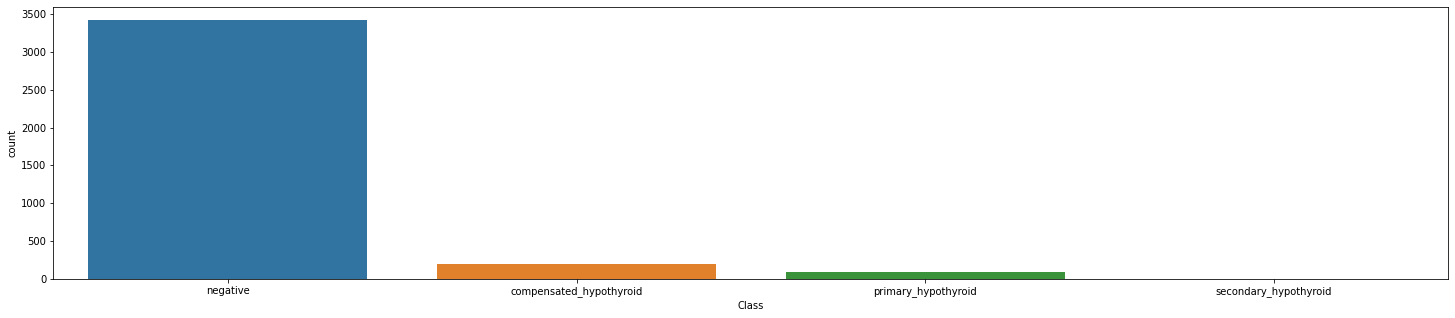

In [ ]:
plt.figure(figsize=(25, 5))
sns.countplot(x='Class', data=data)
plt.show()

In [ ]:
data.Class.value_counts()

negative                   3420
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

Еще раз убеждаемся, что классы сильно несбалансированы, особенно класс 'secondary_hypothyroid', посмотрим на него отдельно.

In [ ]:
data[data['Class']=='secondary_hypothyroid']

age sex on_thyroxine  ...   FTI referral_source                  Class
1492  41.0   M            f  ...   NaN           other  secondary_hypothyroid
2694  46.0   F            f  ...  54.0           other  secondary_hypothyroid

[2 rows x 28 columns]

Судя по представленным данных, не могу заметить ничего необычного. Возможно, это связано с тем, что случаев вторичного гипотиреоза намного меньше, чем даже субклинического(компенсированного) или первичного.

##Univariate analysis

###Continuous features

####Age

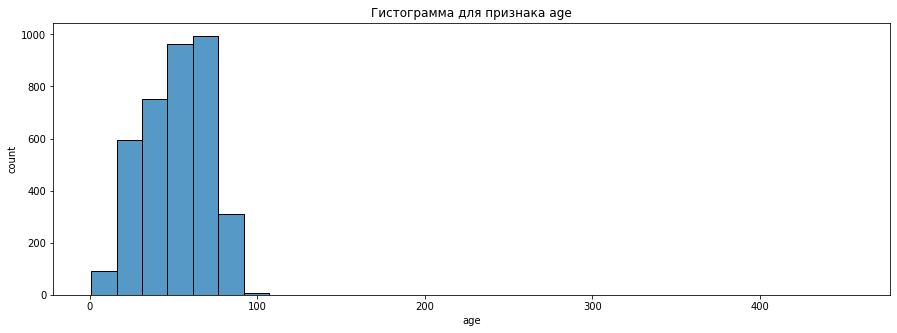

In [ ]:
plot_hist('age', data, bins=30)

Видим, что скорее всего есть выброс в этом признаке, давайте построим ящик с "усам" чтобы убедиться в этом.

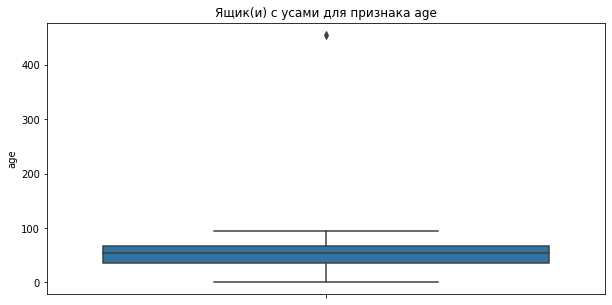

In [ ]:
plot_box('age',data)

Как и предполагалось, в данных есть выброс, удалим его.

In [ ]:
data = data[data['age']<=150]

Снова построим гистограмму

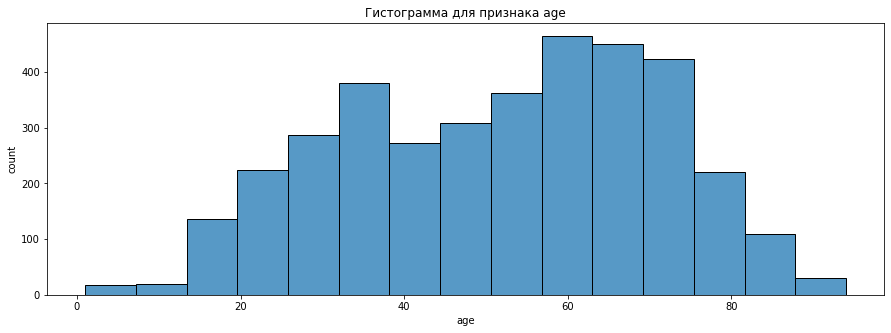

In [ ]:
plot_hist('age', data, bins=15)

Видим, что распределение не похоже на нормальное, проведем тест чтобы убедиться

In [ ]:
check_normality(data['age'].dropna(),'age')

Statistics=490.796, p=0.000
Гипотеза о нормальности выборки по признаку 'age'должна быть отклонена


Посмотрим теперь на распределения признака отдельно для каждого таргета.

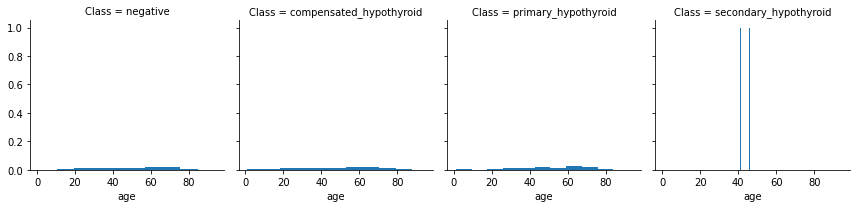

In [ ]:
g = sns.FacetGrid(data, col="Class", palette="muted")
g = g.map(plt.hist, "age", density=True)

Видим, что из-за высокого дисбаланса классов, графики получились не очень коректные, поэтому построим их еще раз, но уже без таргета "secondary_hypthyroid".

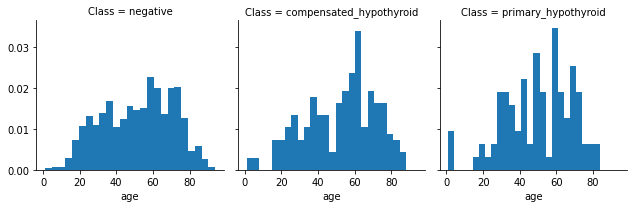

In [ ]:
g = sns.FacetGrid(data[data['Class']!='secondary_hypothyroid'], col="Class", palette="muted")
g = g.map(plt.hist, "age", density=True, bins=25)

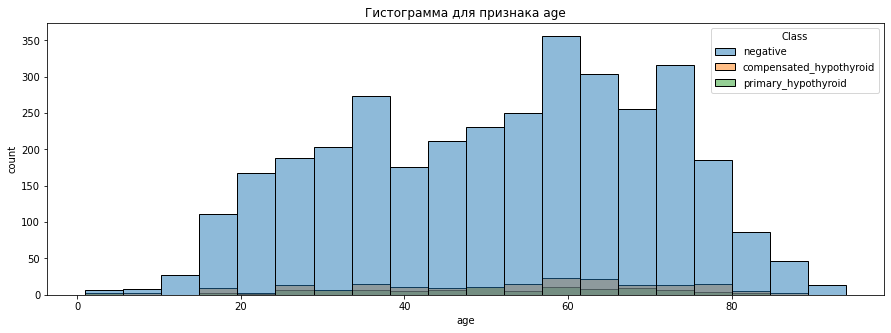

In [ ]:
plot_hist('age',data[data['Class']!='secondary_hypothyroid'],feat2 = 'Class', bins = 20)

К сожалению, разбиение данных по таргетам не внесло существенных изменений в гистограммах.

Проверим значимость различия между выборками, взятыми по таргету

In [ ]:
check_significance('age',data)

Statistics=0.060, p=0.513
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и compensated_hypothyroid взяты из одного распределения
Statistics=0.078, p=0.605
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и primary_hypothyroid взяты из одного распределения
Statistics=0.115, p=0.339
Нельзя отвергнуть гипотезу о том, что выборки c таргетами compensated_hypothyroid и primary_hypothyroid взяты из одного распределения


Как видим, различие в выборках не значимо, значит данный признак скорее всего никак не поможет классифицировать объекты(

Построим также ящики с усами отдельно для каждого таргета, чтобы проверить наличие выбросов

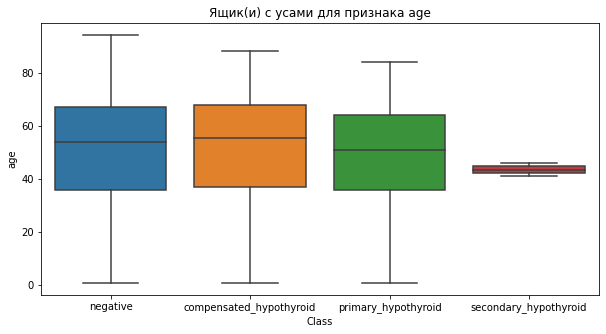

In [ ]:
plot_box('age',data,'Class')

####TSH -  Thyroid Stimulating Hormone Test

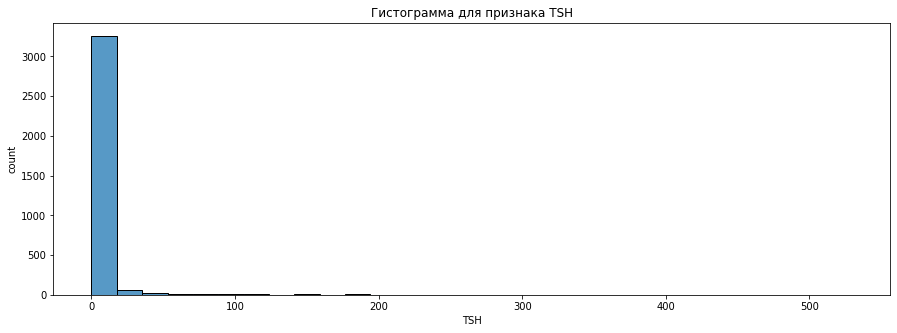

In [ ]:
plot_hist('TSH', data, bins=30)

Видим, что скорее всего есть выбросы в этом признаке, но сначала посмотрим на распределения признака отдельно для каждого таргета.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


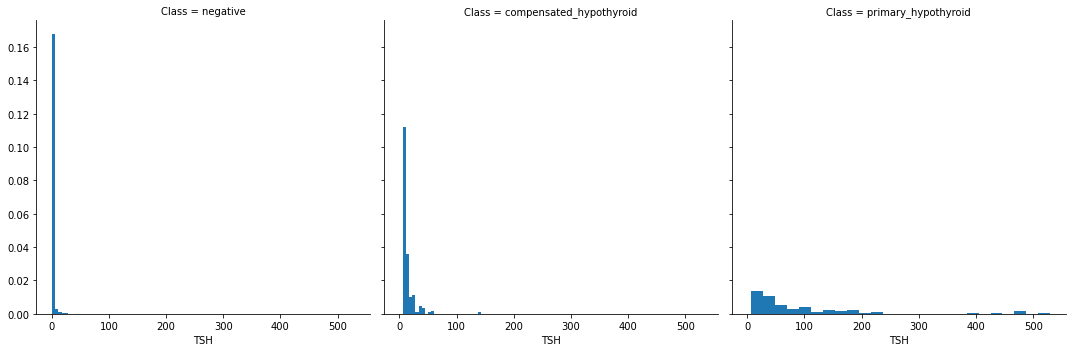

In [ ]:
g = sns.FacetGrid(data[data['Class']!='secondary_hypothyroid'], col="Class", palette="muted",size = 5)
g = g.map(plt.hist, "TSH", density=True, bins=25)

Как, видим, вывод о наличии выброса уже не так однозначен. Построим ящики с усами для каждого таргета, чтобы посмотреть на наличие выбросов.

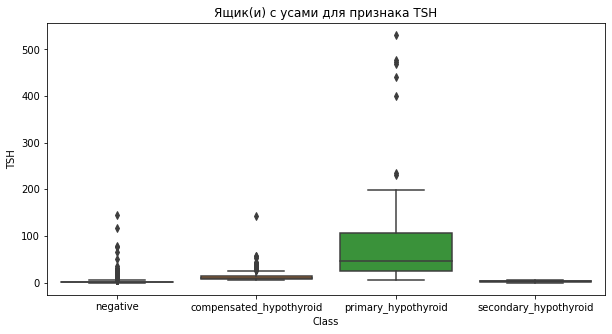

In [ ]:
plot_box('TSH',data,'Class')

Как и предполагалось, в данных есть выбросы, но поскольку классы очень несбалансированы, удалим выбросы только из доминирующего класса.

In [ ]:
data_new = remove_outliers_box('TSH',data,classes=['negative'])

Снова построим гистограмму

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


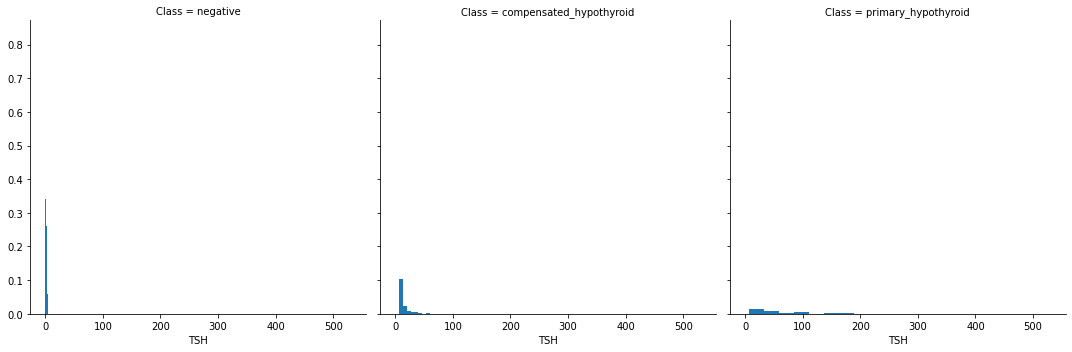

In [ ]:
g = sns.FacetGrid(data_new[data_new['Class']!='secondary_hypothyroid'], col="Class", palette="muted",size = 5)
g = g.map(plt.hist, "TSH", density=True, bins=20)

Распределения все еще далеки от нормального, но мы видим что, данный признак значим.

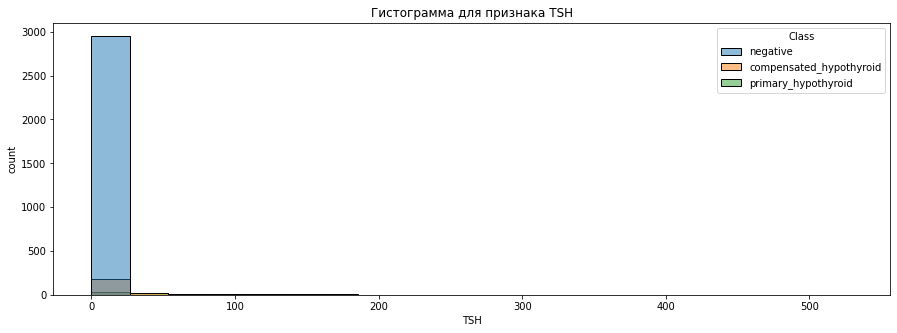

In [ ]:
plot_hist('TSH',data_new[data_new['Class']!='secondary_hypothyroid'],feat2 = 'Class', bins = 20)

Проверим значимость различия между выборками, взятыми по таргету

In [ ]:
check_significance('TSH',data_new.dropna(subset=['TSH']))

Statistics=0.050, p=0.740
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и compensated_hypothyroid взяты из одного распределения
Statistics=0.084, p=0.503
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и primary_hypothyroid взяты из одного распределения
Statistics=0.115, p=0.339
Нельзя отвергнуть гипотезу о том, что выборки c таргетами compensated_hypothyroid и primary_hypothyroid взяты из одного распределения


Как видим, различие в выборках не значимо, что довольно странно, поскольку на графиках видны значительные различия в зависимости от таргета.

####T3 - Triiodothyronine

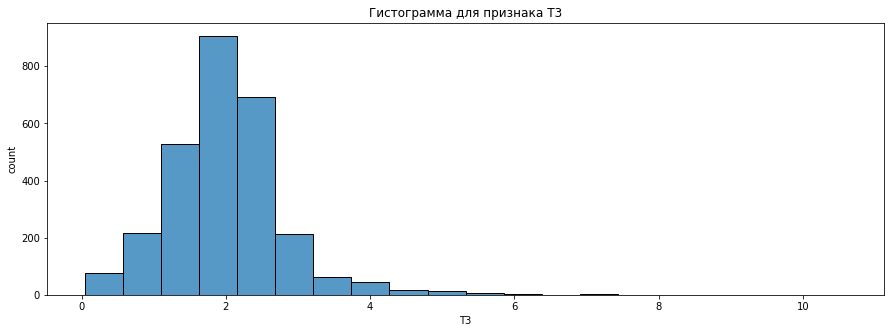

In [ ]:
plot_hist('T3', data_new, bins=20)

Видим, что распределение не похоже на нормальное, проведем тест чтобы убедиться

In [ ]:
check_normality(data_new['T3'].dropna(),'T3')

Statistics=1201.231, p=0.000
Гипотеза о нормальности выборки по признаку 'T3'должна быть отклонена


Посмотрим теперь на распределения признака отдельно для каждого таргета.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


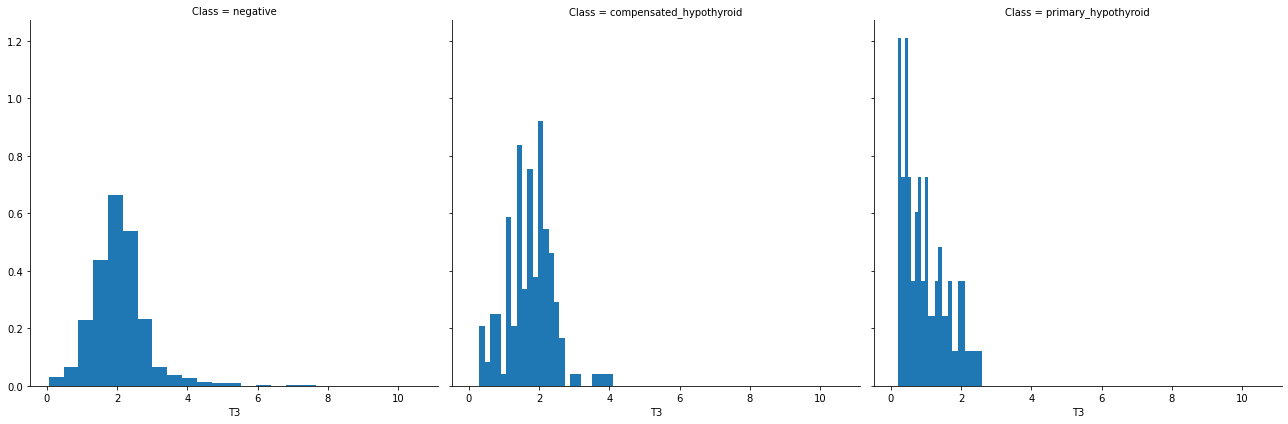

In [ ]:
g = sns.FacetGrid(data_new[data_new['Class']!='secondary_hypothyroid'], col="Class", palette="muted",size=6)
g = g.map(plt.hist, "T3", density=True, bins=25)

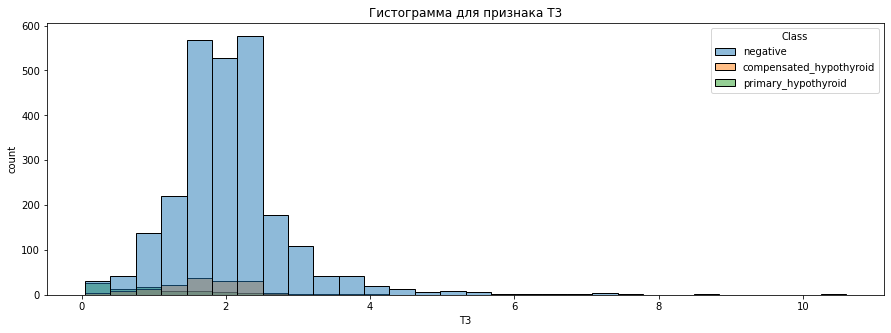

In [ ]:
plot_hist('T3',data_new[data_new['Class']!='secondary_hypothyroid'],feat2 = 'Class', bins = 30)

К сожалению, разбиение данных по таргетам не внесло существенных изменений в гистограммах.

Проверим значимость различия между выборками, взятыми по таргету

In [ ]:
check_significance('T3',data_new)

Statistics=0.050, p=0.740
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и compensated_hypothyroid взяты из одного распределения
Statistics=0.084, p=0.503
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и primary_hypothyroid взяты из одного распределения
Statistics=0.115, p=0.339
Нельзя отвергнуть гипотезу о том, что выборки c таргетами compensated_hypothyroid и primary_hypothyroid взяты из одного распределения


Как видим, различие в выборках не значимо, значит данный признак скорее всего никак не поможет классифицировать объекты(

Построим также ящики с усами отдельно для каждого таргета, чтобы проверить наличие выбросов

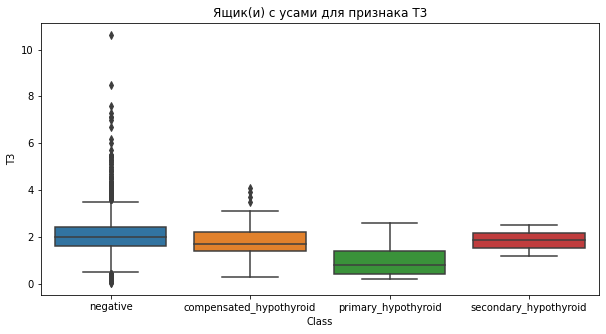

In [ ]:
plot_box('T3',data_new,'Class')

В данных есть выбросы, но поскольку классы очень несбалансированы, удалим выбросы только из доминирующего класса.

In [ ]:
data_new = remove_outliers_box('T3',data_new,classes=['negative'])

####TT4 - Total T4/ Total Thyroxine

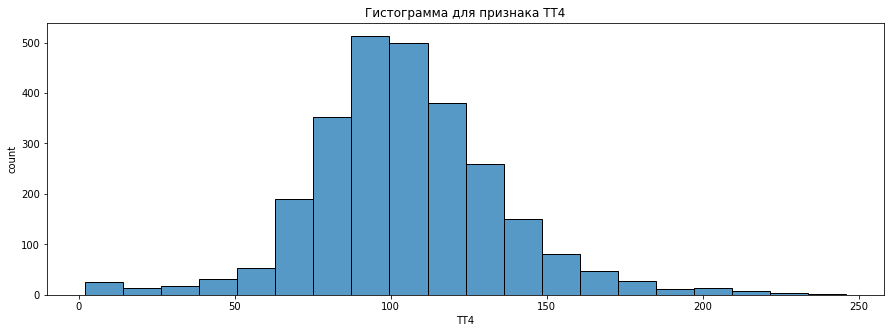

In [ ]:
plot_hist('TT4', data_new, bins=20)

Видим, что распределение похоже на нормальное, проведем тест чтобы убедиться

In [ ]:
check_normality(data_new['TT4'].dropna(),'TT4')

Statistics=152.399, p=0.000
Гипотеза о нормальности выборки по признаку 'TT4'должна быть отклонена


К сожалению, тест показал, что распределение не нормальное.

Посмотрим теперь на распределения признака отдельно для каждого таргета.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


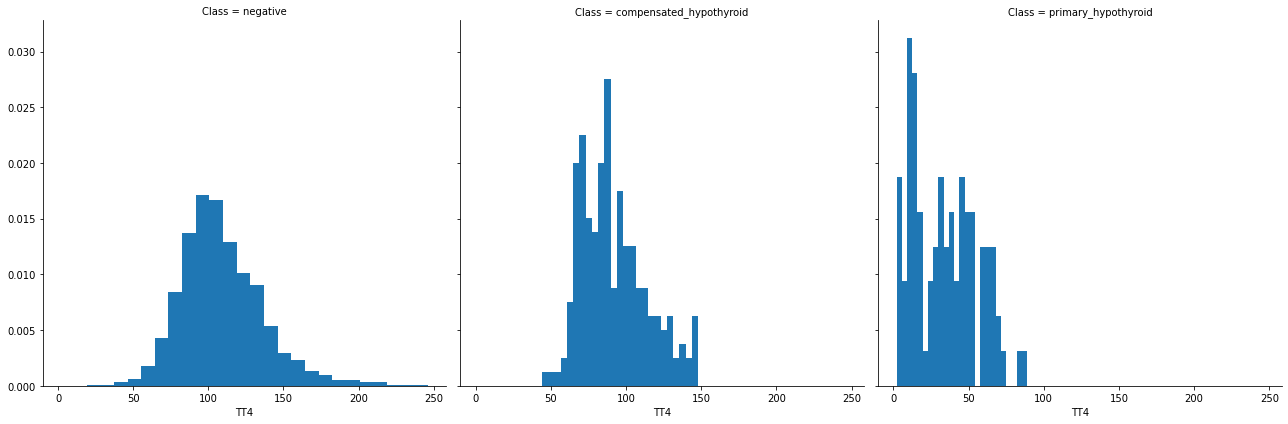

In [ ]:
g = sns.FacetGrid(data_new[data_new['Class']!='secondary_hypothyroid'], col="Class", palette="muted",size=6)
g = g.map(plt.hist, "TT4", density=True, bins=25)

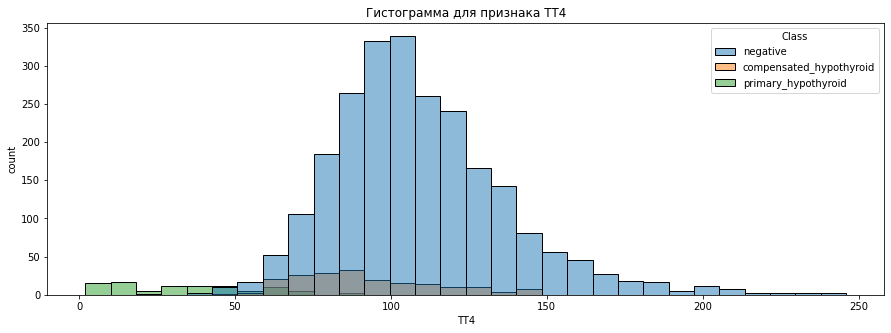

In [ ]:
plot_hist('TT4',data_new[data_new['Class']!='secondary_hypothyroid'],feat2 = 'Class', bins = 30)

К сожалению, разбиение данных по таргетам не внесло существенных изменений в гистограммах.

Проверим значимость различия между выборками, взятыми по таргету

In [ ]:
check_significance('TT4',data_new)

Statistics=0.050, p=0.735
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и compensated_hypothyroid взяты из одного распределения
Statistics=0.098, p=0.327
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и primary_hypothyroid взяты из одного распределения
Statistics=0.115, p=0.339
Нельзя отвергнуть гипотезу о том, что выборки c таргетами compensated_hypothyroid и primary_hypothyroid взяты из одного распределения


Как видим, различие в выборках не значимо, значит данный признак може не помочь классифицировать объекты(

Построим также ящики с усами отдельно для каждого таргета, чтобы проверить наличие выбросов

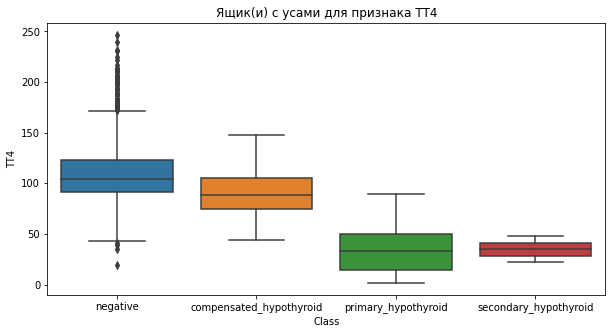

In [ ]:
plot_box('TT4',data_new,'Class')

В данных есть выбросы, но поскольку классы очень несбалансированы, удалим выбросы только из доминирующего класса.

In [ ]:
data_new = remove_outliers_box('TT4',data_new,classes=['negative'])

####T4U - Thyroxine utilization rates

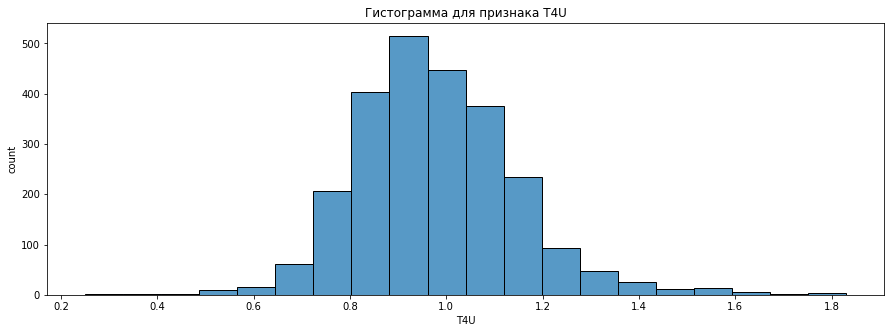

In [ ]:
plot_hist('T4U', data_new, bins=20)

Видим, что распределение похоже на нормальное, проведем тест чтобы убедиться

In [ ]:
check_normality(data_new['T4U'].dropna(),'T4U')

Statistics=292.019, p=0.000
Гипотеза о нормальности выборки по признаку 'T4U'должна быть отклонена


К сожалению, тест показал, что распределение не нормальное.

Посмотрим теперь на распределения признака отдельно для каждого таргета.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


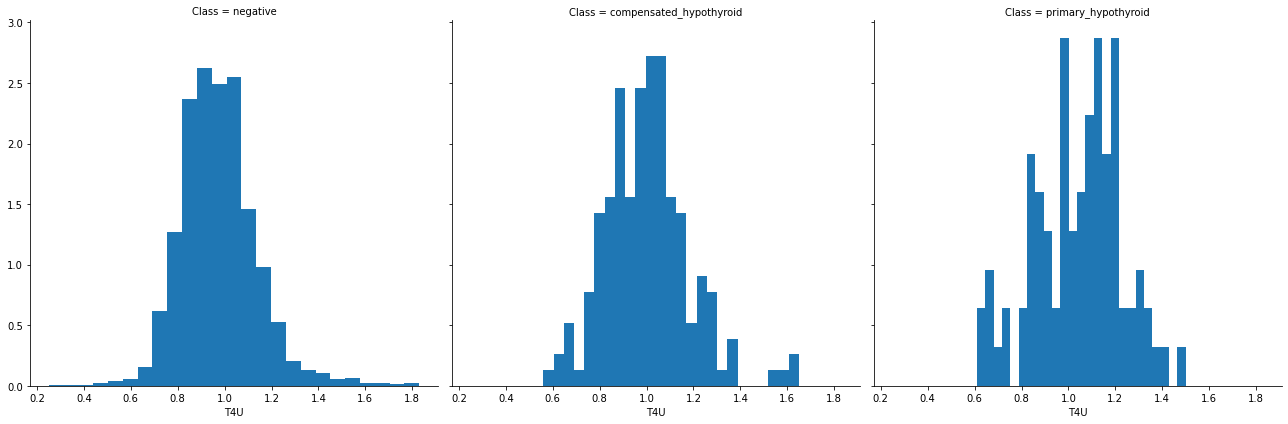

In [ ]:
g = sns.FacetGrid(data_new[data_new['Class']!='secondary_hypothyroid'], col="Class", palette="muted",size=6)
g = g.map(plt.hist, "T4U", density=True, bins=25)

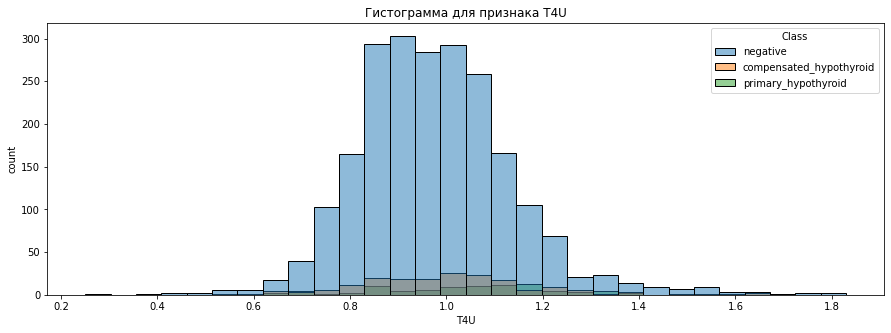

In [ ]:
plot_hist('T4U',data_new[data_new['Class']!='secondary_hypothyroid'],feat2 = 'Class', bins = 30)

К сожалению, разбиение данных по таргетам не внесло существенных изменений в гистограммах.

Проверим значимость различия между выборками, взятыми по таргету

In [ ]:
check_significance('T4U',data_new)

Statistics=0.051, p=0.726
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и compensated_hypothyroid взяты из одного распределения
Statistics=0.097, p=0.329
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и primary_hypothyroid взяты из одного распределения
Statistics=0.115, p=0.339
Нельзя отвергнуть гипотезу о том, что выборки c таргетами compensated_hypothyroid и primary_hypothyroid взяты из одного распределения


Как видим, различие в выборках не значимо, значит данный признак може не помочь классифицировать объекты(

Построим также ящики с усами отдельно для каждого таргета, чтобы проверить наличие выбросов

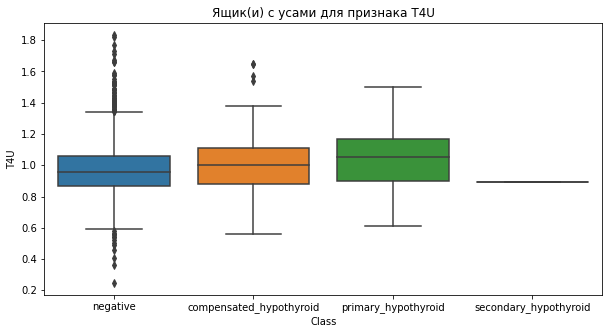

In [ ]:
plot_box('T4U',data_new,'Class')

В данных есть выбросы, но поскольку классы очень несбалансированы, удалим выбросы только из доминирующего класса.

In [ ]:
data_new = remove_outliers_box('T4U',data_new,classes=['negative'])

####FTI - Thyroid Function Tests

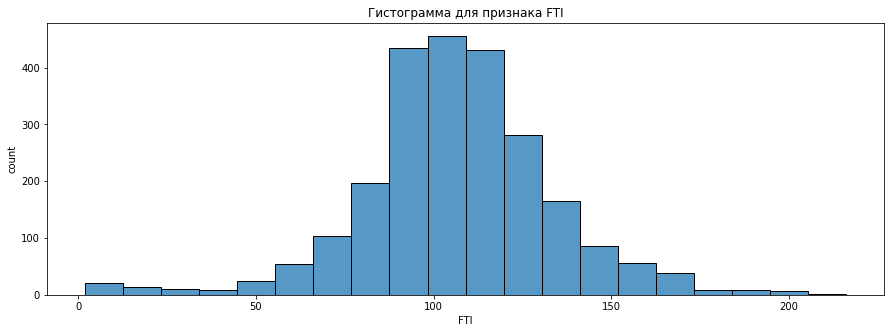

In [ ]:
plot_hist('FTI', data_new, bins=20)

Видим, что распределение похоже на нормальное, проведем тест чтобы убедиться

In [ ]:
check_normality(data_new['FTI'].dropna(),'T4U')

Statistics=143.255, p=0.000
Гипотеза о нормальности выборки по признаку 'T4U'должна быть отклонена


К сожалению, тест показал, что распределение не нормальное.

Посмотрим теперь на распределения признака отдельно для каждого таргета.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


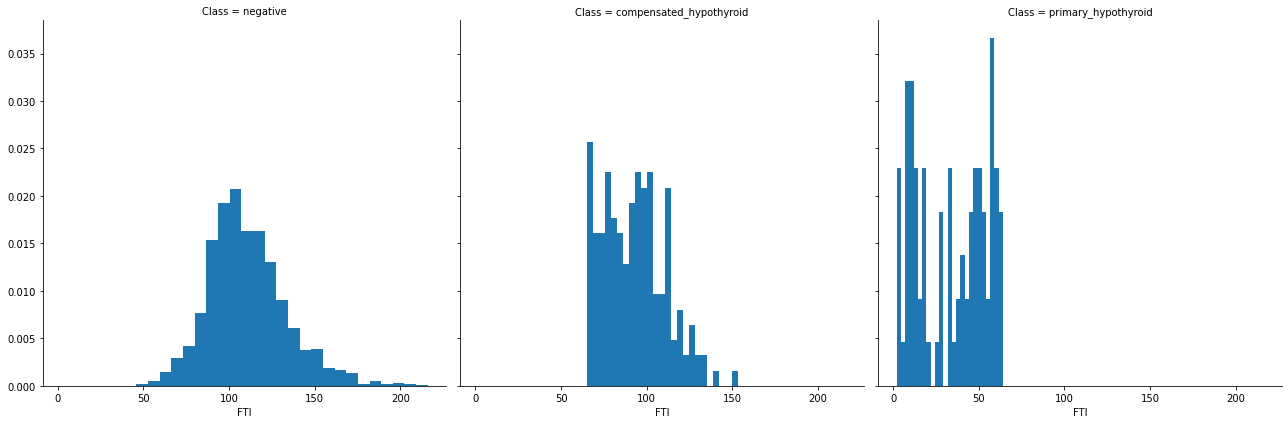

In [ ]:
g = sns.FacetGrid(data_new[data_new['Class']!='secondary_hypothyroid'], col="Class", palette="muted",size=6)
g = g.map(plt.hist, "FTI", density=True, bins=25)

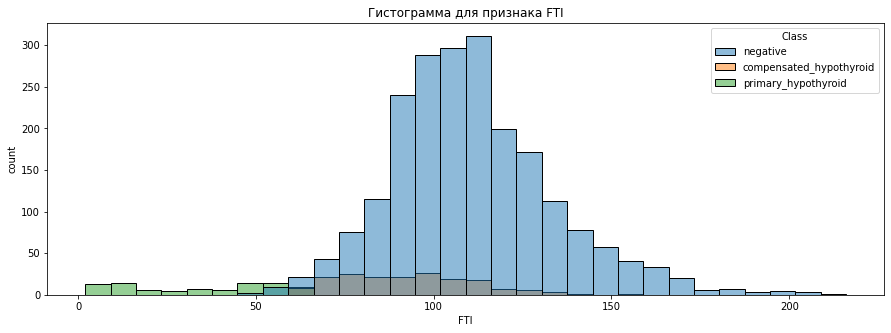

In [ ]:
plot_hist('FTI',data_new[data_new['Class']!='secondary_hypothyroid'],feat2 = 'Class', bins = 30)

К сожалению, разбиение данных по таргетам не внесло существенных изменений в гистограммах.

Проверим значимость различия между выборками, взятыми по таргету

In [ ]:
check_significance('FTI',data_new)

Statistics=0.061, p=0.501
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и compensated_hypothyroid взяты из одного распределения
Statistics=0.105, p=0.251
Нельзя отвергнуть гипотезу о том, что выборки c таргетами negative и primary_hypothyroid взяты из одного распределения
Statistics=0.115, p=0.339
Нельзя отвергнуть гипотезу о том, что выборки c таргетами compensated_hypothyroid и primary_hypothyroid взяты из одного распределения


Как видим, различие в выборках не значимо, значит данный признак может не помочь классифицировать объекты(

Построим также ящики с усами отдельно для каждого таргета, чтобы проверить наличие выбросов

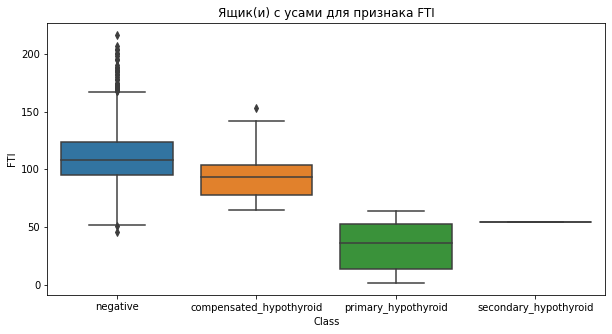

In [ ]:
plot_box('FTI',data_new,'Class')

В данных есть выбросы, но поскольку классы очень несбалансированы, удалим выбросы только из доминирующего класса.

In [ ]:
data_new = remove_outliers_box('FTI',data_new,classes=['negative'])

Вывод по Continuous features:
Удивительно, но к сожалению тесты на значимость выборок показали, что ни один из признаков не дает значимого различия для таргетов(

In [ ]:
len(data_new)/len(data)

0.6430304664330008

In [ ]:
data_new.isna().sum()

age                           0
sex                          88
on_thyroxine                  0
query_on_thyroxine            0
on_antithyroid_medication     0
sick                          0
pregnant                      0
thyroid_surgery               0
I131_treatment                0
query_hypothyroid             0
query_hyperthyroid            0
lithium                       0
goitre                        0
tumor                         0
hypopituitary                 0
psych                         0
TSH_measured                  0
TSH                           0
T3_measured                   0
T3                           46
TT4_measured                  0
TT4                           5
T4U_measured                  0
T4U                          25
FTI_measured                  0
FTI                          25
referral_source               0
Class                         0
dtype: int64

Как видим, у нас осталось только 63% данных, то есть мы удалили достаточно много, даже мб слишком. Но это позволило нам уменьшить имбаланс классов и еще, благодаря этому уменьшиломь количество пропусков в данных.

###Category features

In [ ]:
unsignificant_features = []

####Sex

In [ ]:
feature = 'sex'

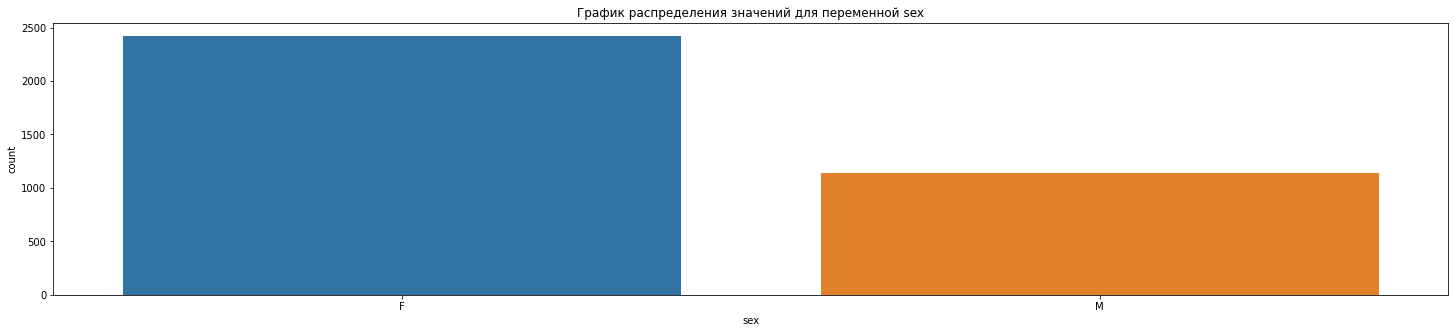

In [ ]:
plot_dist_categ('sex',data)

В выборке преобладают люди женского пола

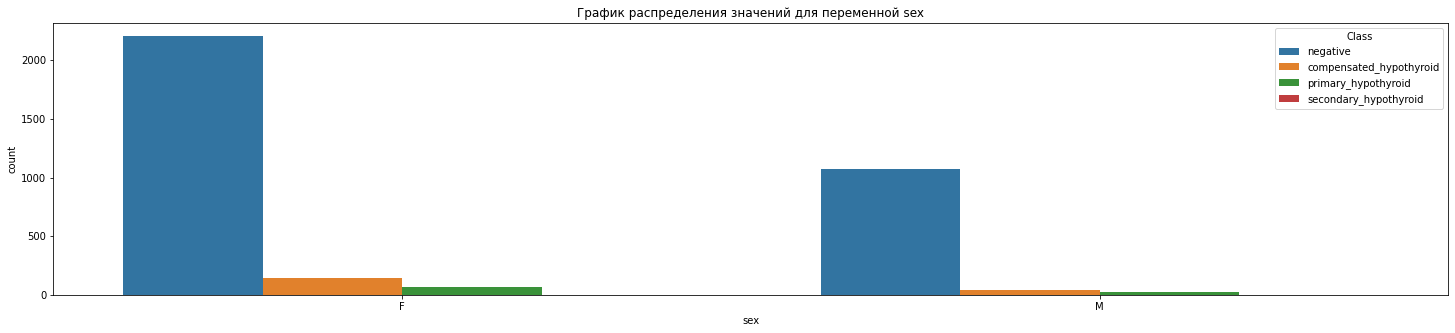

In [ ]:
plot_dist_categ('sex',data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test('sex',data_new)

Contingency tabel
Class  compensated_hypothyroid  ...  secondary_hypothyroid
sex                             ...                       
F                          145  ...                      1
M                           42  ...                      1

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Гипотеза H0 отклонена


Проведенный тест $\chi^2$ показал что признак 'sex' значимый

In [ ]:
unsignificant_features.append(feature)

####on_thyroxine

In [ ]:
feature = 'on_thyroxine'

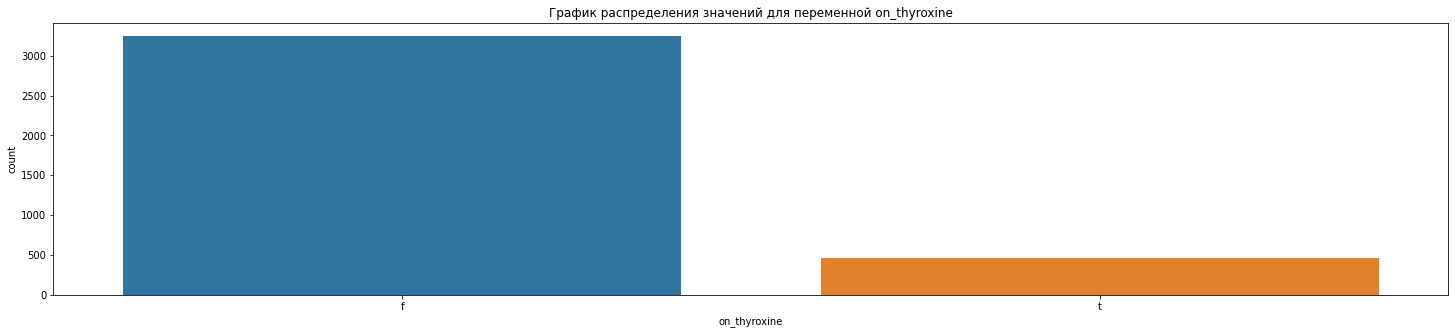

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'on_thyroxine' равным False


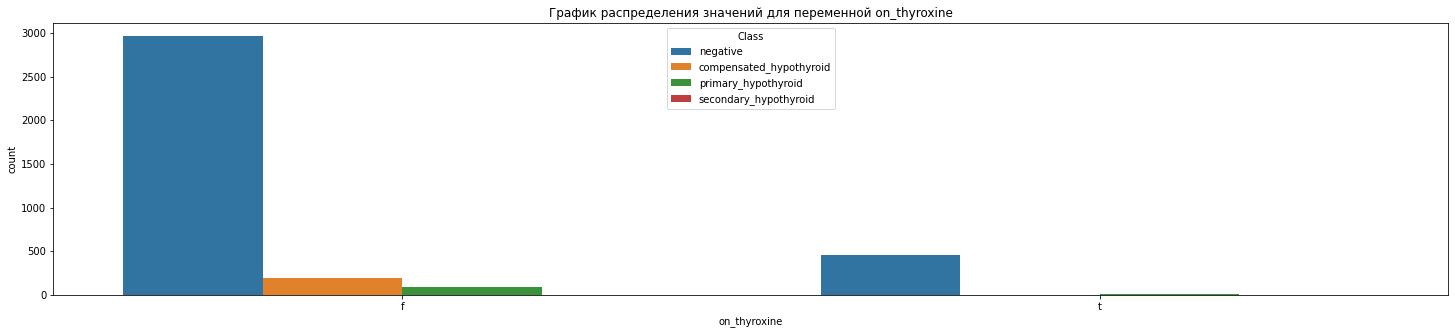

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class         compensated_hypothyroid  ...  secondary_hypothyroid
on_thyroxine                           ...                       
f                                 194  ...                      2
t                                   0  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Гипотеза H0 отклонена


Проведенный тест $\chi^2$ показал что признак 'on_thyroxine' значимый

In [ ]:
unsignificant_features.append(feature)

####query_on_thyroxine 

In [ ]:
feature = 'query_on_thyroxine'

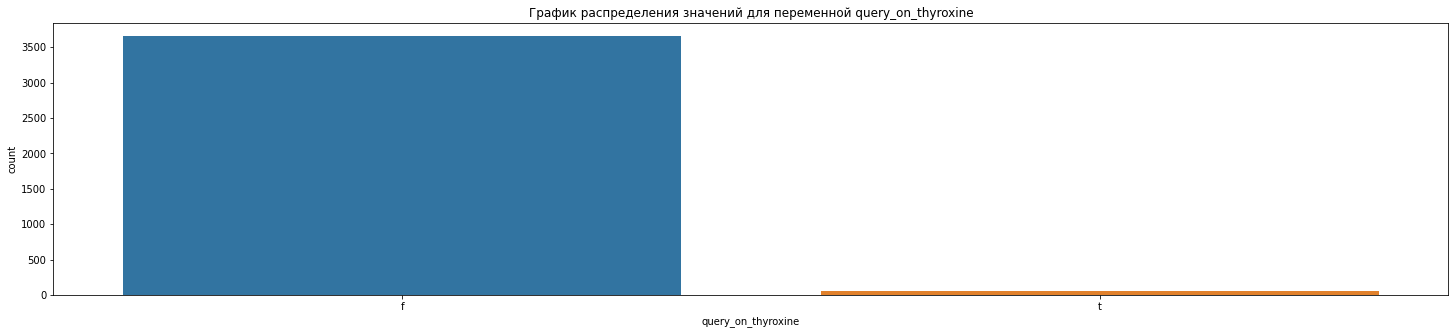

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'query_on_thyroxine' равным False


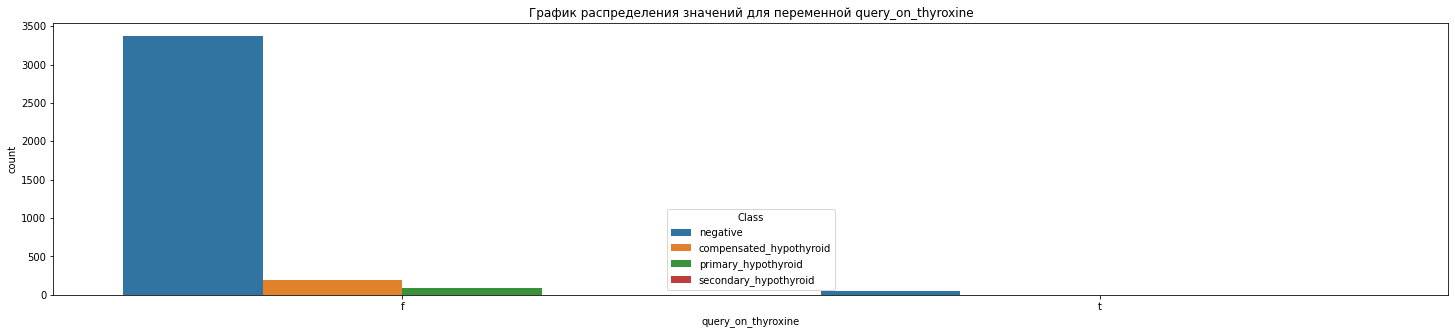

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class               compensated_hypothyroid  ...  secondary_hypothyroid
query_on_thyroxine                           ...                       
f                                       191  ...                      2
t                                         3  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'query_on_thyroxine' незначимый

####on_antithyroid_medication

In [ ]:
feature = 'on_antithyroid_medication'

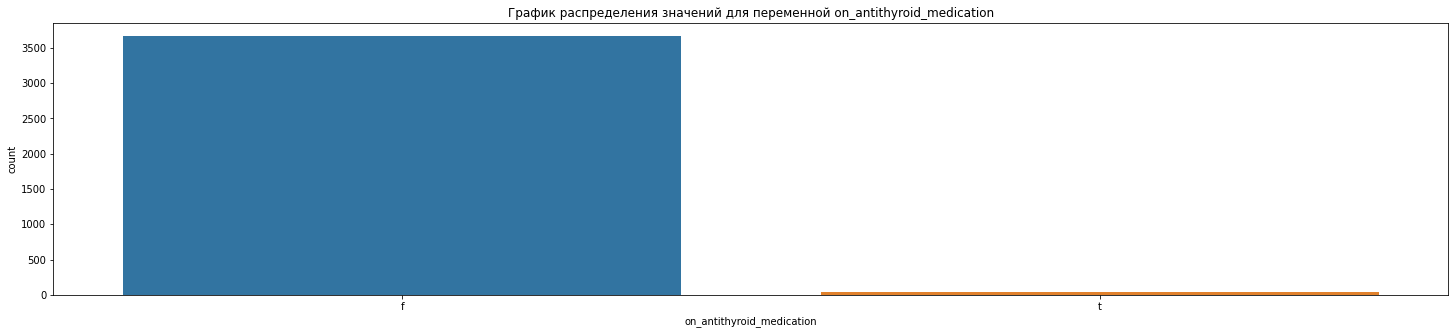

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'on_antithyroid_medication' равным False


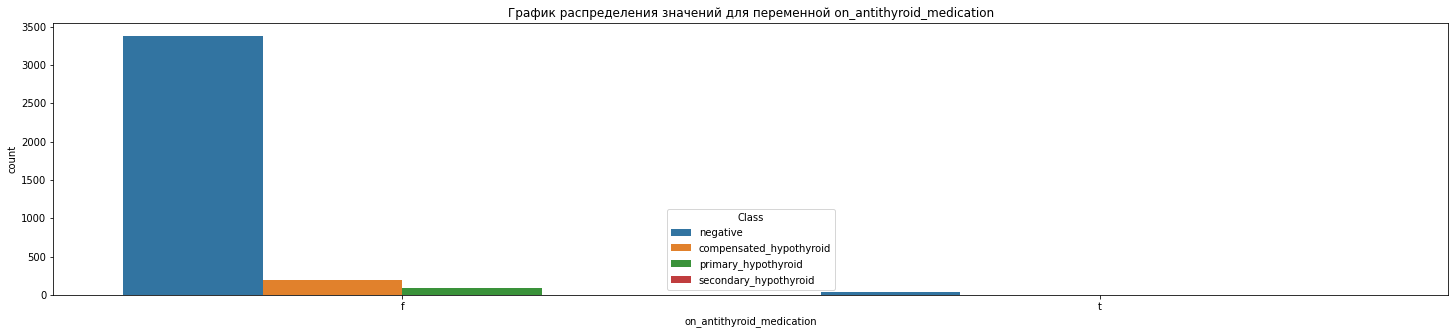

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class                      compensated_hypothyroid  ...  secondary_hypothyroid
on_antithyroid_medication                           ...                       
f                                              193  ...                      2
t                                                1  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'on_antithyroid_medication' незначимый

####sick

In [ ]:
feature = 'sick'

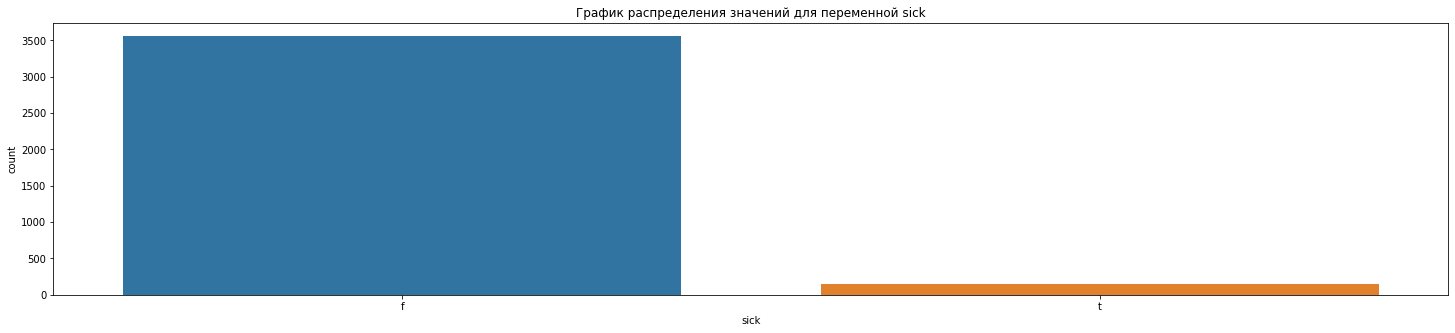

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'sick' равным False


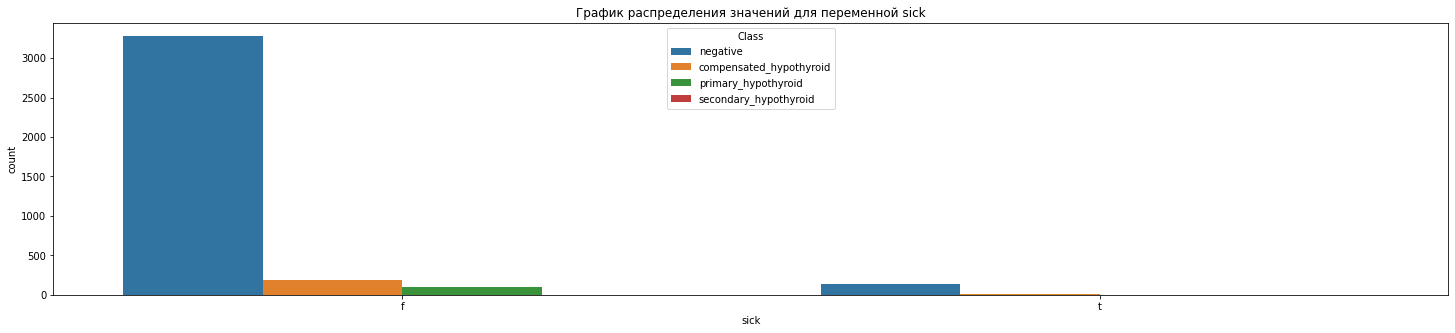

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class  compensated_hypothyroid  ...  secondary_hypothyroid
sick                            ...                       
f                          183  ...                      2
t                           11  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'sick' незначимый

####pregnant

In [ ]:
feature = 'pregnant'

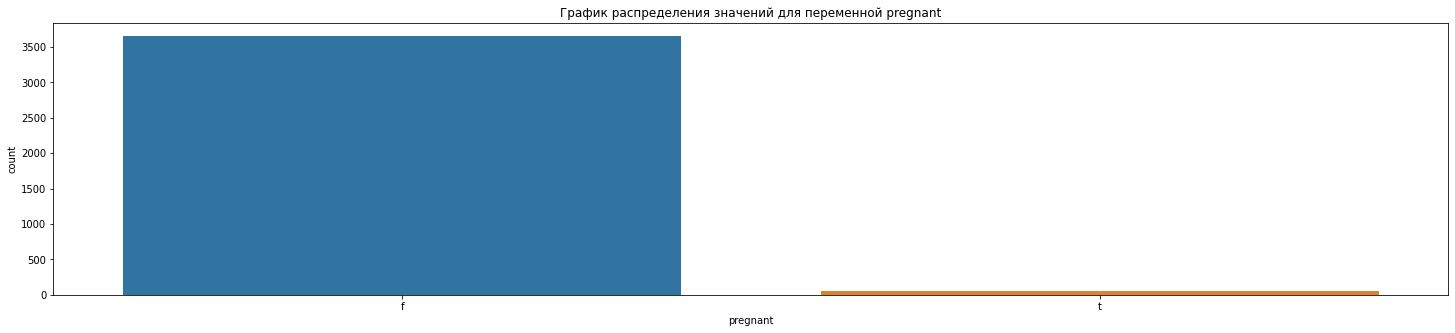

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'pregnant' равным False


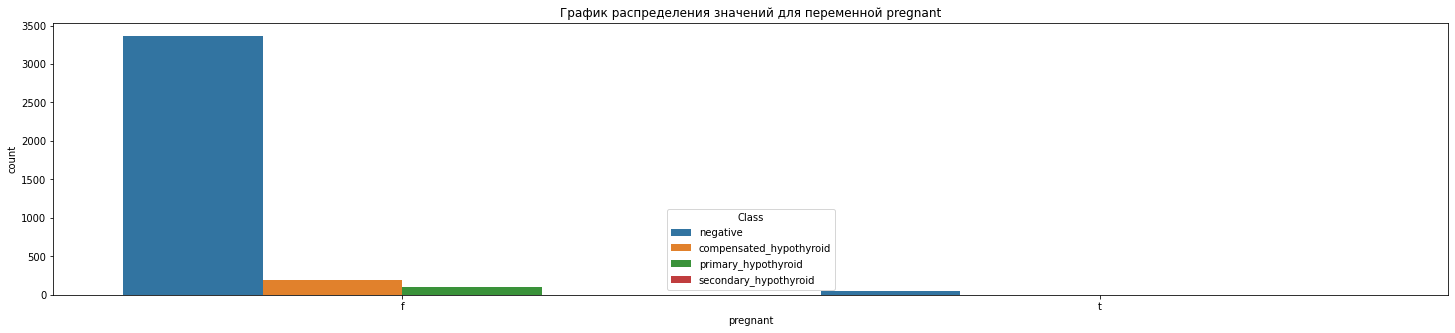

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class     compensated_hypothyroid  ...  secondary_hypothyroid
pregnant                           ...                       
f                             194  ...                      2
t                               0  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'pregnant' незначимый

####thyroid_surgery

In [ ]:
feature = 'thyroid_surgery'

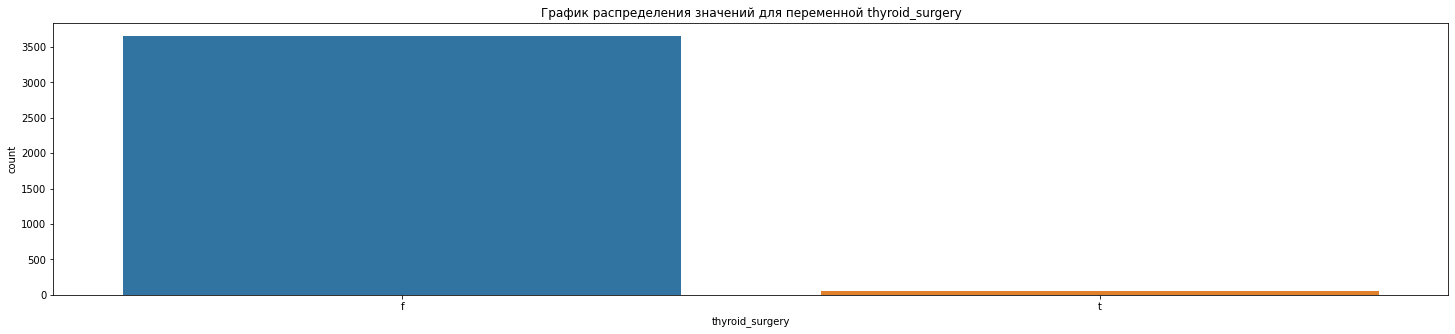

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'thyroid_surgery' равным False


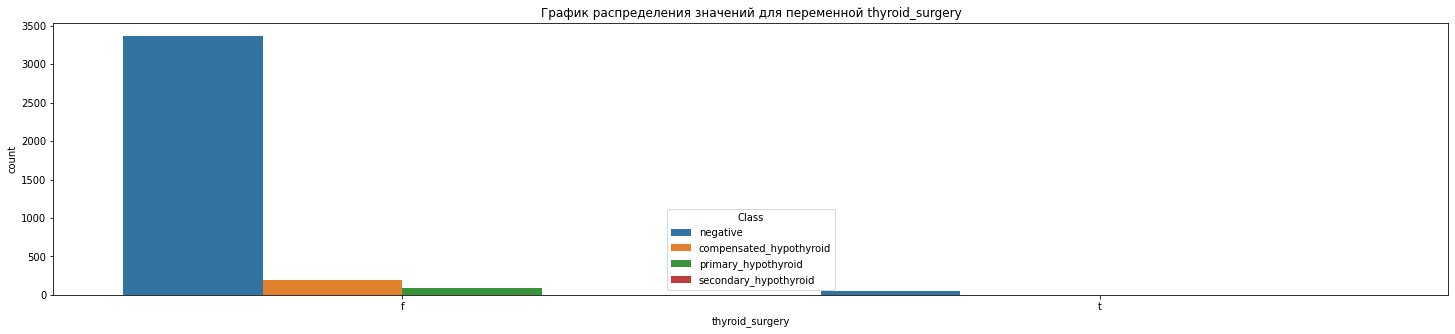

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class            compensated_hypothyroid  ...  secondary_hypothyroid
thyroid_surgery                           ...                       
f                                    194  ...                      2
t                                      0  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'thyroid_surgery' незначимый

####I131_treatment

In [ ]:
feature = 'I131_treatment'

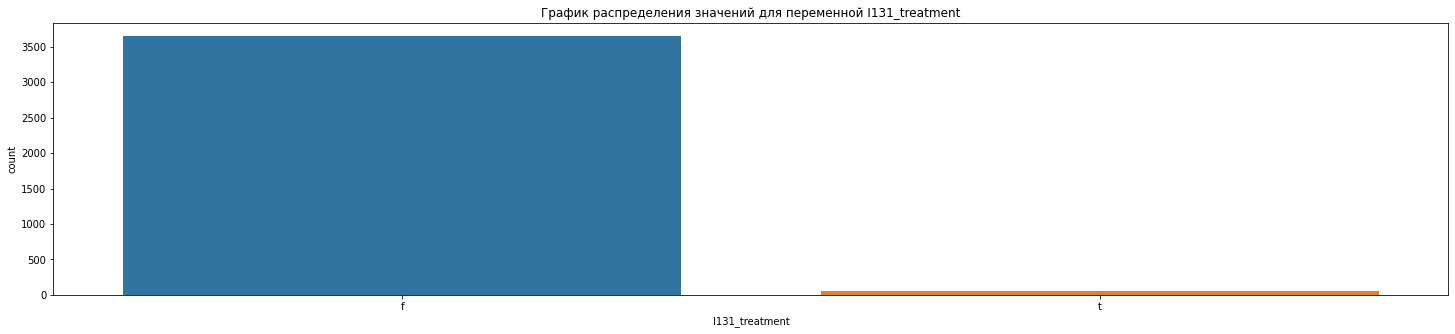

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'on_antithyroid_medication' равным False


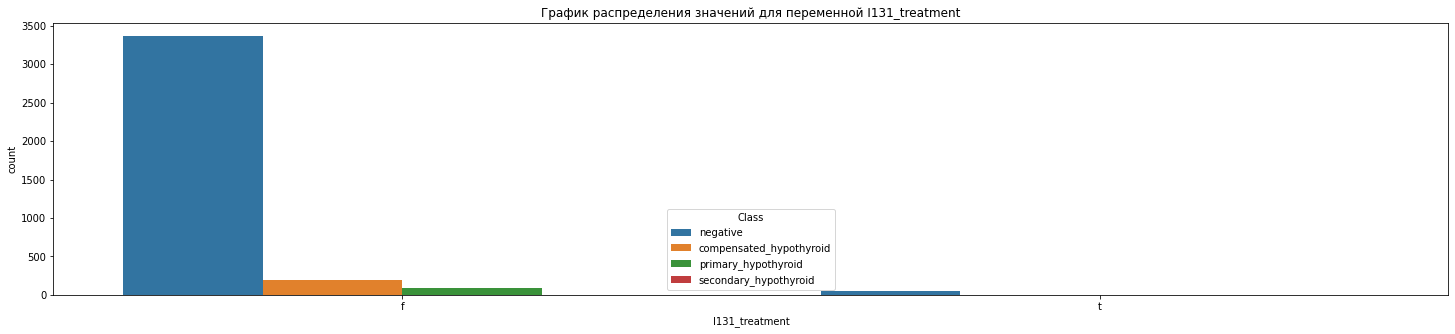

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class           compensated_hypothyroid  ...  secondary_hypothyroid
I131_treatment                           ...                       
f                                   191  ...                      2
t                                     3  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'I131_treatment' незначимый

####query_hypothyroid

In [ ]:
feature = 'query_hypothyroid'

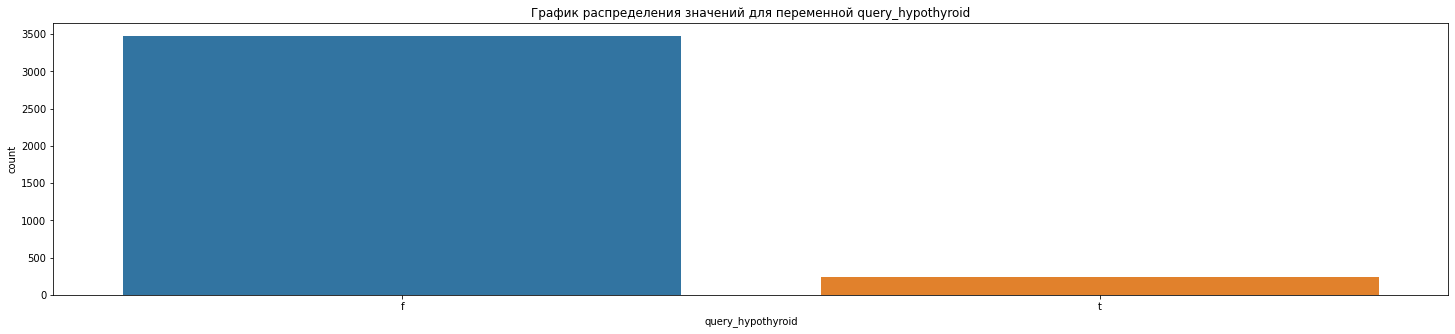

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'query_hypothyroid' равным False


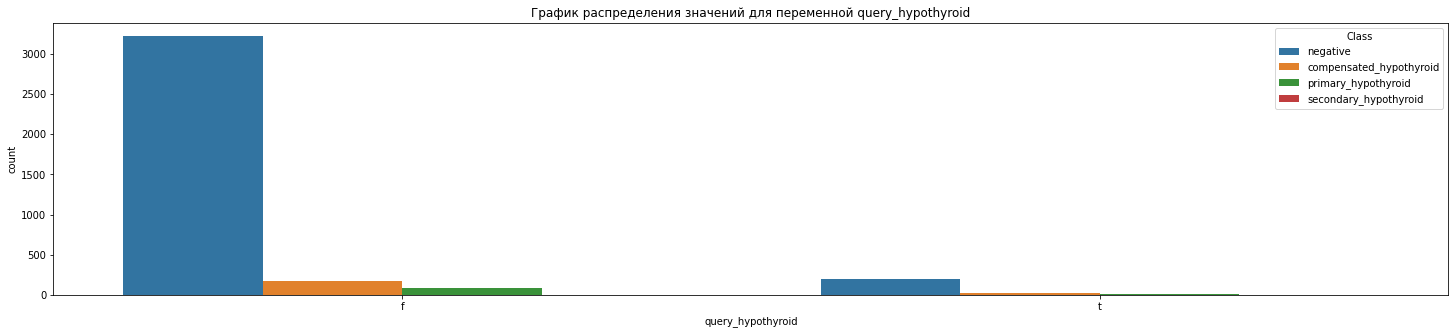

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class              compensated_hypothyroid  ...  secondary_hypothyroid
query_hypothyroid                           ...                       
f                                      167  ...                      1
t                                       27  ...                      1

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Гипотеза H0 отклонена


Проведенный тест $\chi^2$ показал что признак 'query_hypothyroid' значим

In [ ]:
unsignificant_features.append(feature)

####query_hyperthyroid

In [ ]:
feature = 'query_hyperthyroid'

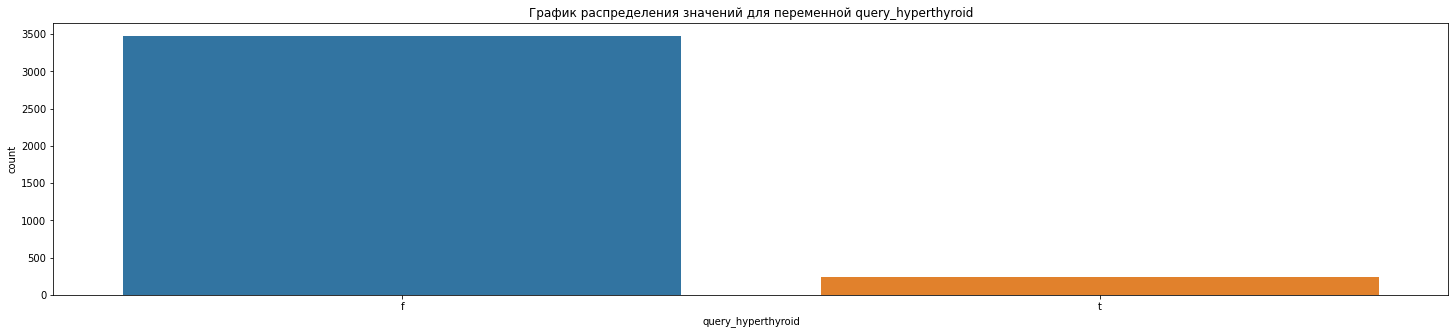

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'query_hyperthyroid' равным False


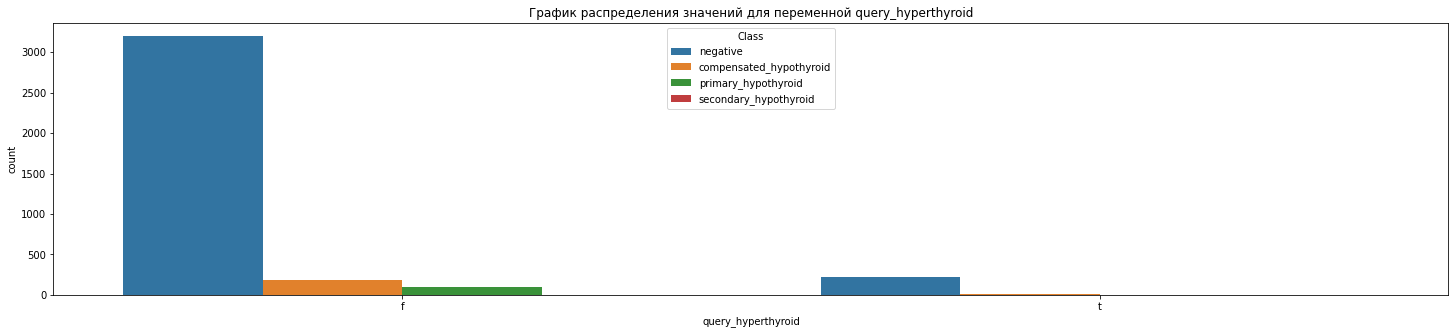

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class               compensated_hypothyroid  ...  secondary_hypothyroid
query_hyperthyroid                           ...                       
f                                       182  ...                      2
t                                        12  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'query_hyperthyroid' незначим

####lithium

In [ ]:
feature = 'lithium'

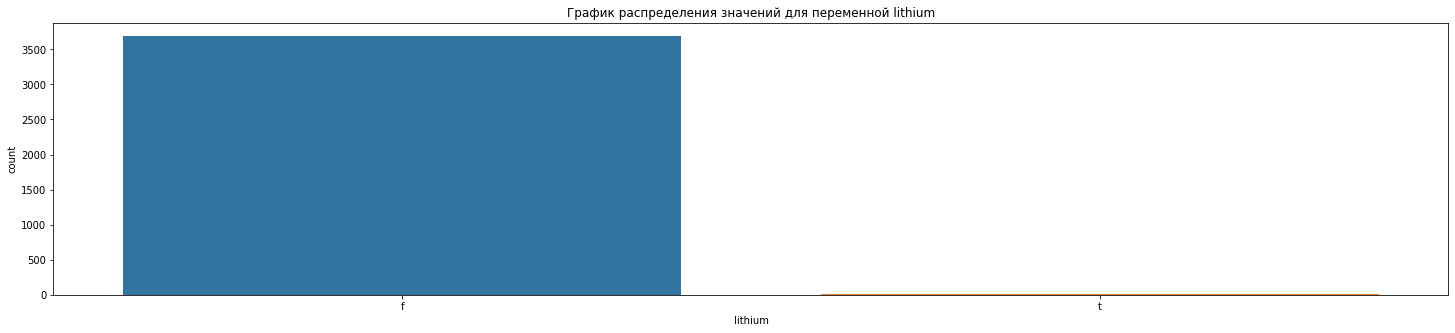

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'lithium' равным False


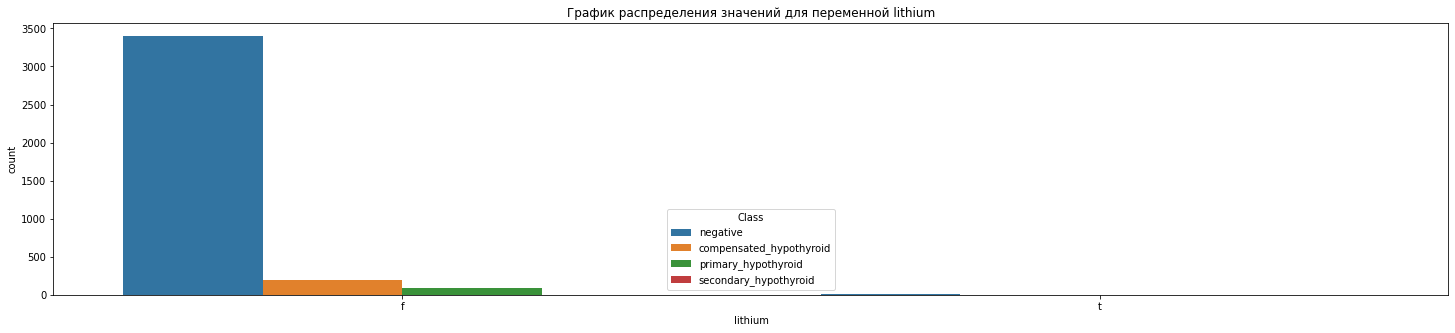

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class    compensated_hypothyroid  ...  secondary_hypothyroid
lithium                           ...                       
f                            193  ...                      2
t                              1  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'lithium' незначим

####goitre

In [ ]:
feature = 'goitre'

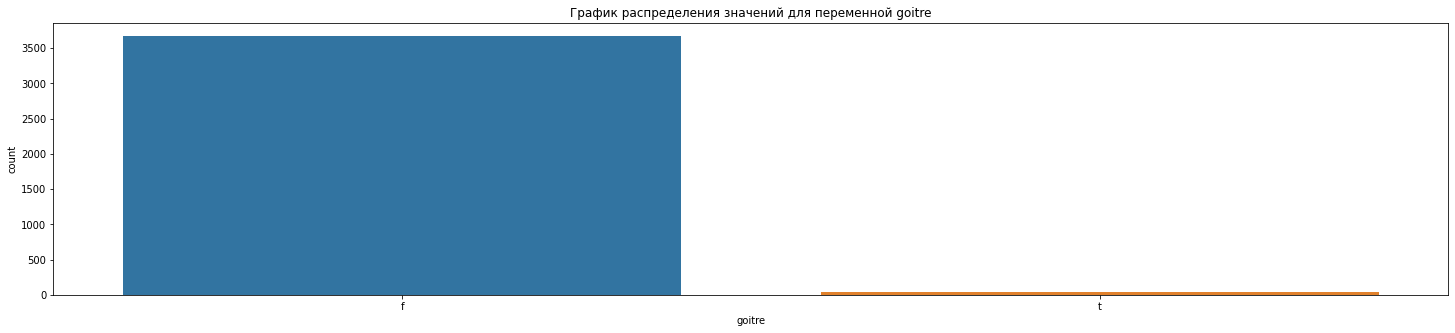

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'goitre' равным False


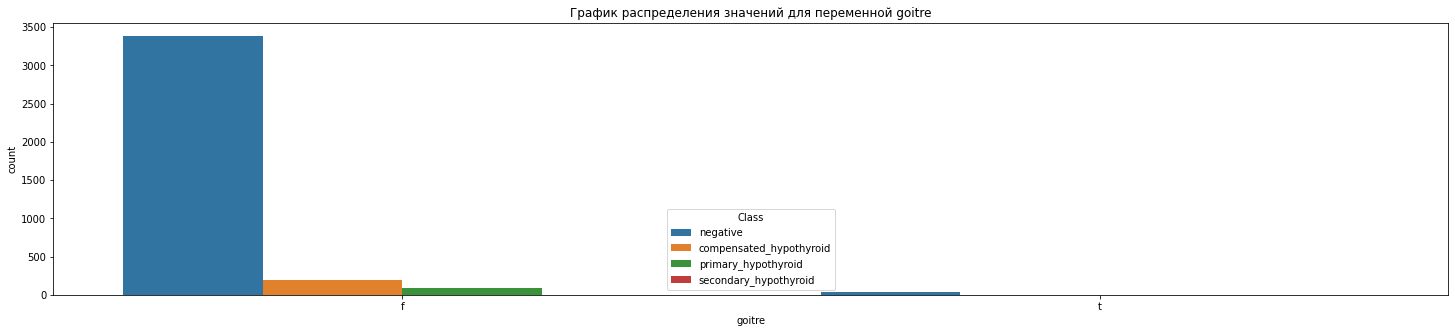

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class   compensated_hypothyroid  ...  secondary_hypothyroid
goitre                           ...                       
f                           194  ...                      2
t                             0  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'goitre' незначим

####tumor

In [ ]:
feature = 'tumor'

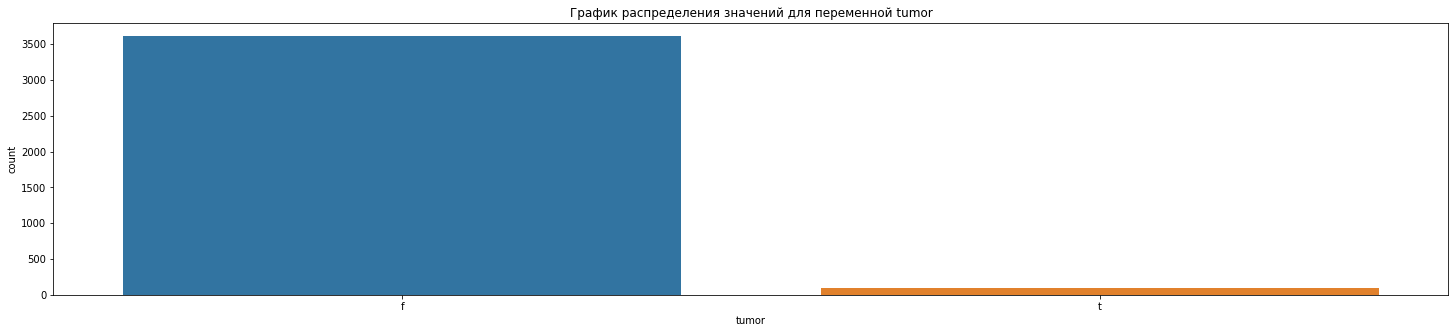

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'tumor' равным False


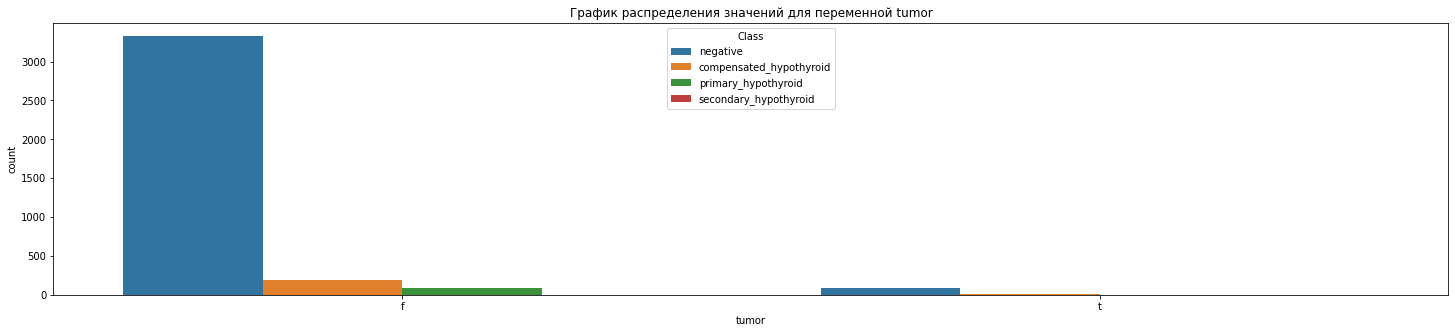

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class  compensated_hypothyroid  ...  secondary_hypothyroid
tumor                           ...                       
f                          188  ...                      2
t                            6  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'tumor' незначим

####hypopituitary

In [ ]:
feature = 'hypopituitary'

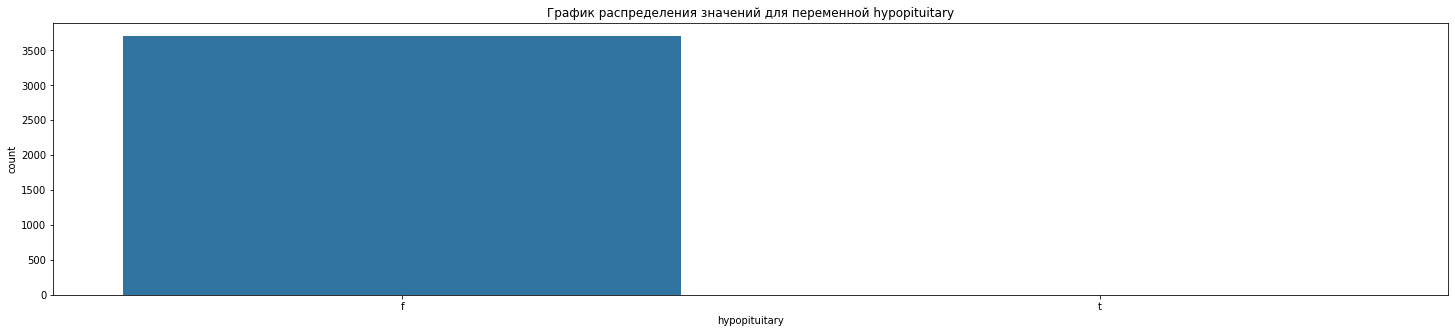

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'hypopituitary' равным False


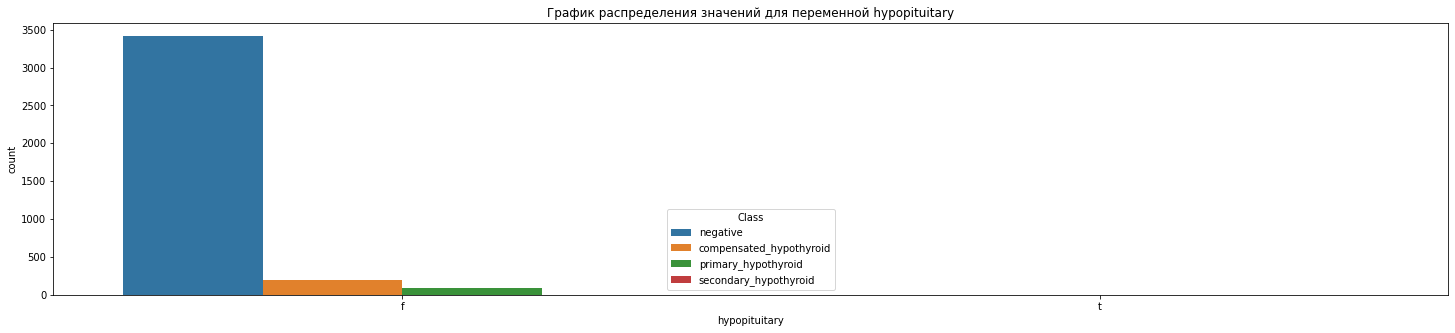

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class          compensated_hypothyroid  ...  secondary_hypothyroid
hypopituitary                           ...                       
f                                  194  ...                      2

[1 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'hypopituitary' незначим

####psych

In [ ]:
feature = 'psych'

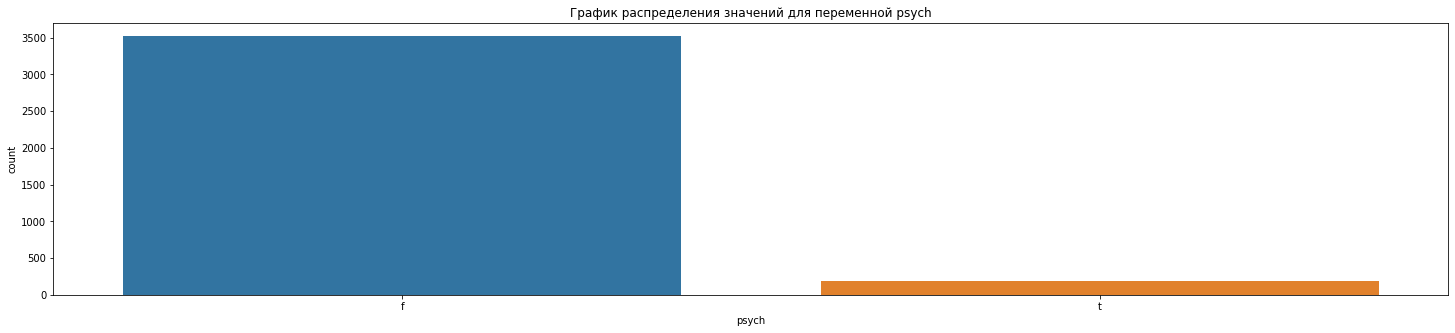

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'psych' равным False


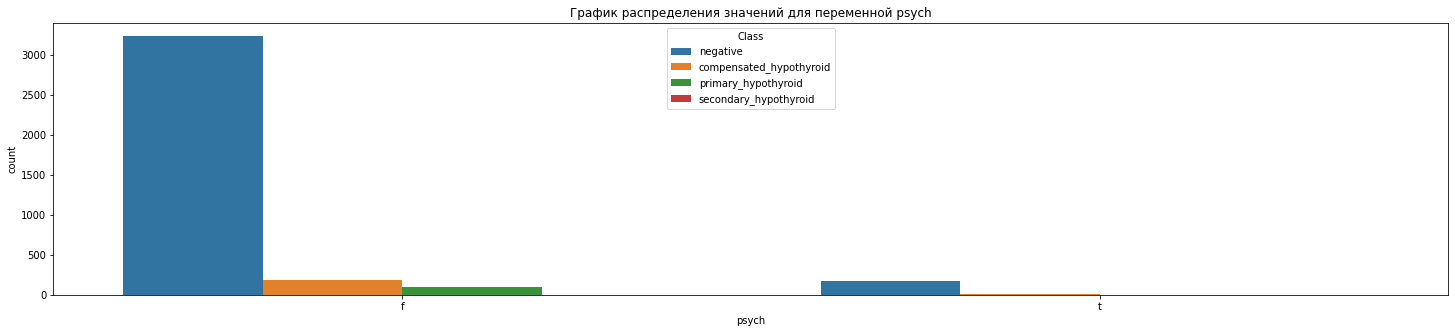

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class  compensated_hypothyroid  ...  secondary_hypothyroid
psych                           ...                       
f                          186  ...                      2
t                            8  ...                      0

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Гипотеза H0 отклонена


Проведенный тест $\chi^2$ показал что признак 'psych' значим

In [ ]:
unsignificant_features.append(feature)

####TSH_measured

In [ ]:
feature = 'TSH_measured'

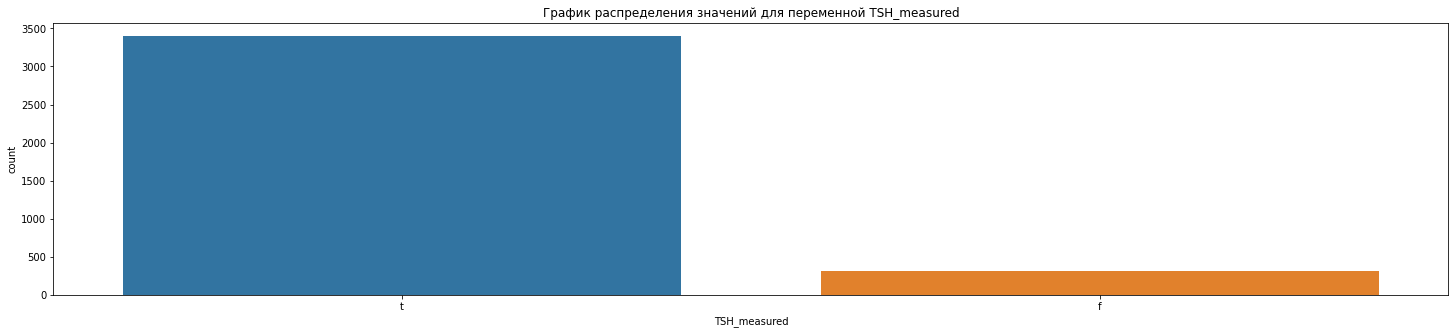

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'TSH_measured' равным TRUE


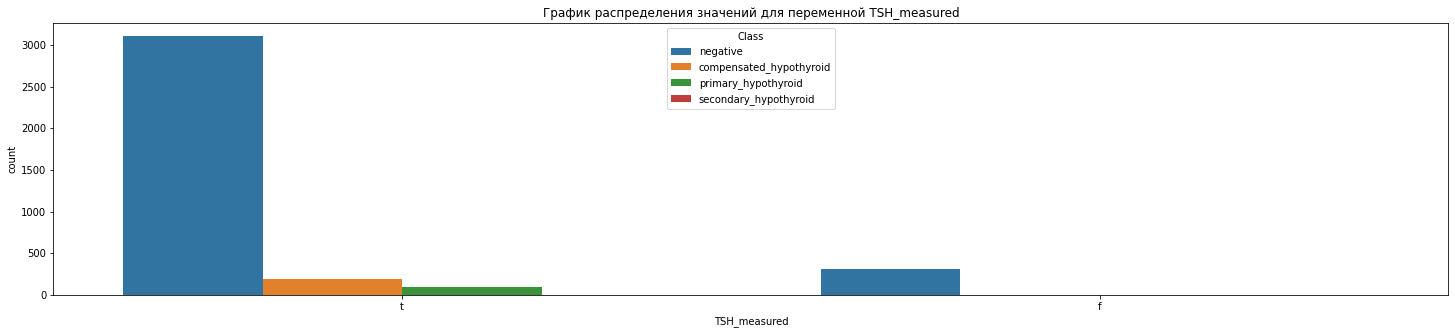

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class         compensated_hypothyroid  ...  secondary_hypothyroid
TSH_measured                           ...                       
t                                 194  ...                      2

[1 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Нельзя отвергнуть гипотезу H0


Проведенный тест $\chi^2$ показал что признак 'TSH_measured' незначим. Но несмотря на это, данный столбец является индикатором пропущенных значений, поэтому оставим его.

In [ ]:
unsignificant_features.append(feature)

####T3_measured

In [ ]:
feature = 'T3_measured'

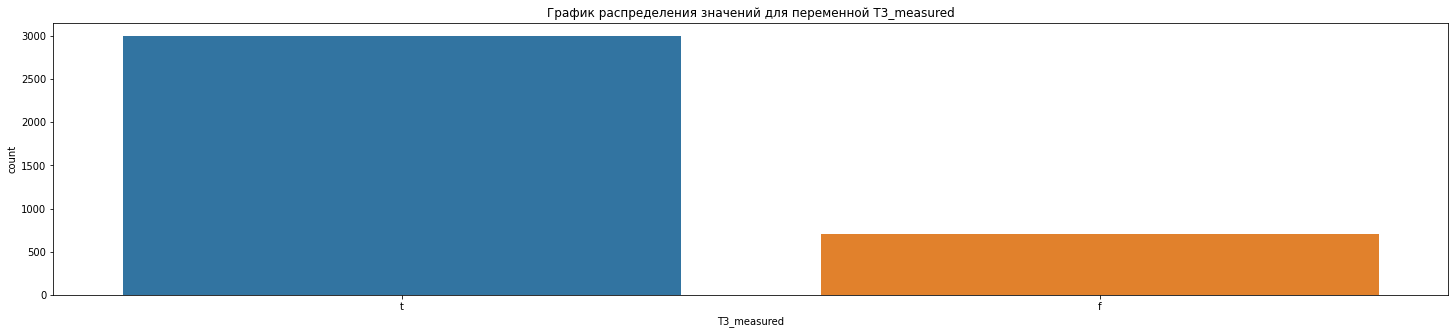

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'goitre' равным TRUE


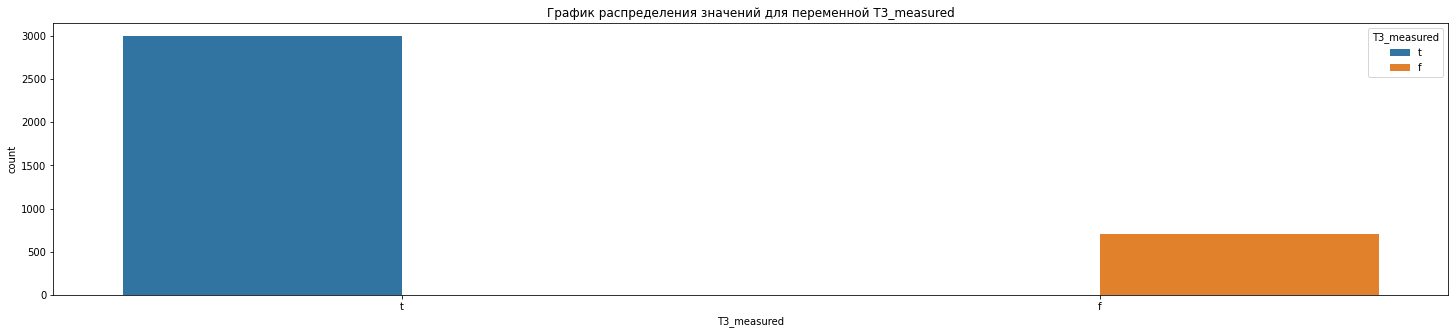

In [ ]:
plot_dist_categ(feature,data,'T3_measured')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class        compensated_hypothyroid  ...  secondary_hypothyroid
T3_measured                           ...                       
f                                 37  ...                      0
t                                157  ...                      2

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Гипотеза H0 отклонена


Проведенный тест $\chi^2$ показал что признак 'T3_measured' значим

In [ ]:
unsignificant_features.append(feature)

####TT4_measured

In [ ]:
feature = 'TT4_measured'

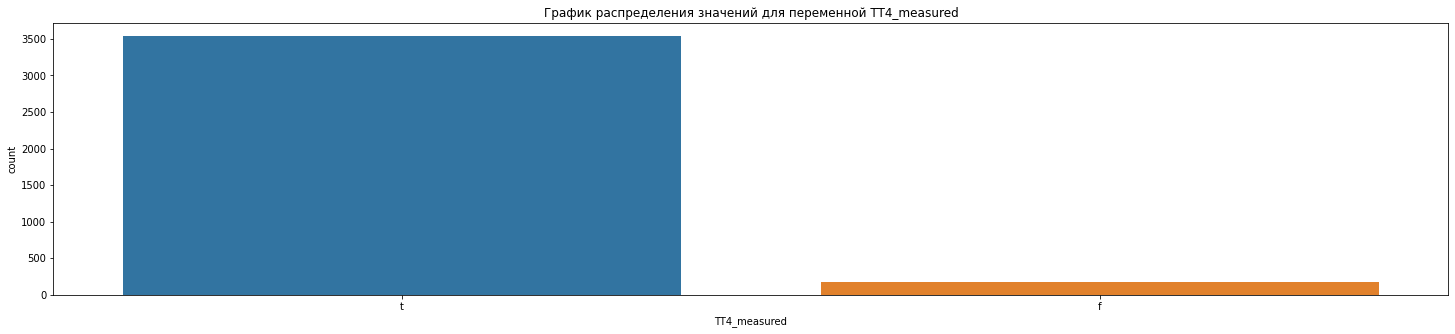

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'TT4_measured' равным True


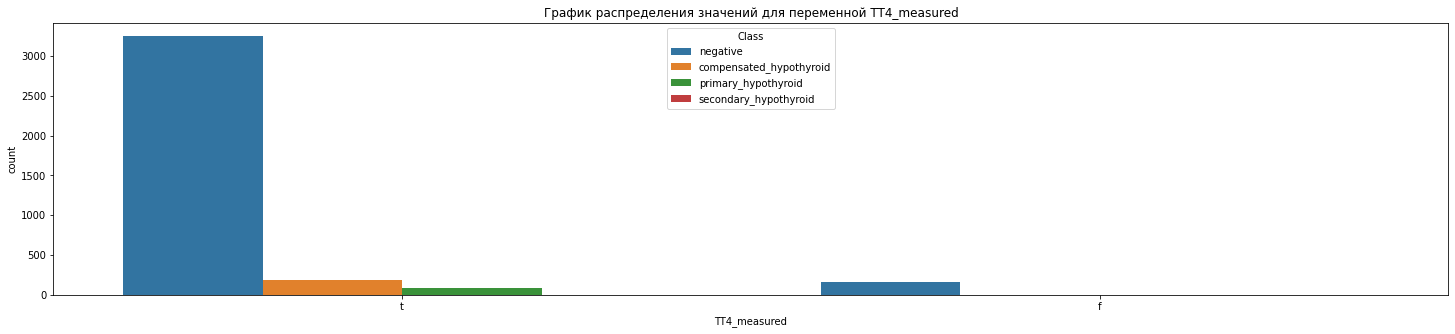

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class         compensated_hypothyroid  ...  secondary_hypothyroid
TT4_measured                           ...                       
f                                   2  ...                      0
t                                 192  ...                      2

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Гипотеза H0 отклонена


Проведенный тест $\chi^2$ показал что признак 'TT4_measured' незначим. Но несмотря на это, данный столбец является индикатором пропущенных значений, поэтому оставим его.

In [ ]:
unsignificant_features.append(feature)

####T4U_measured

In [ ]:
feature = 'T4U_measured'

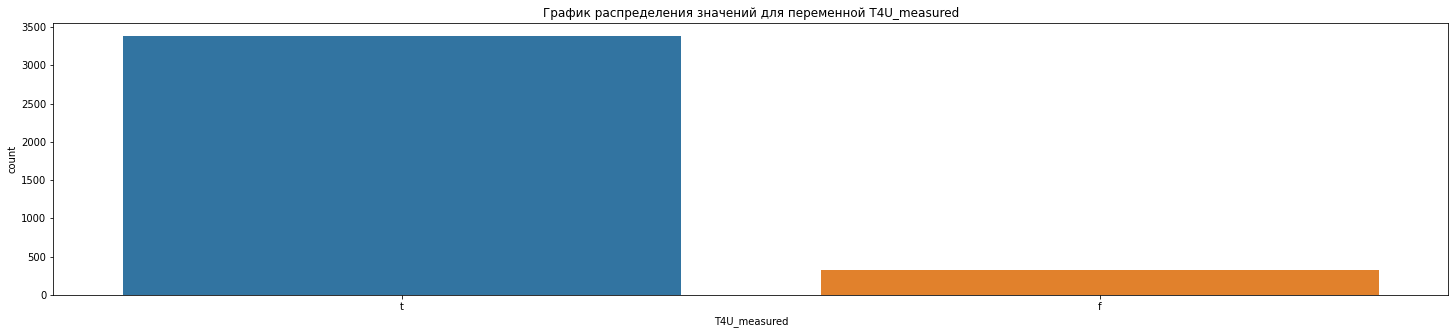

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'T4U_measured' равным True


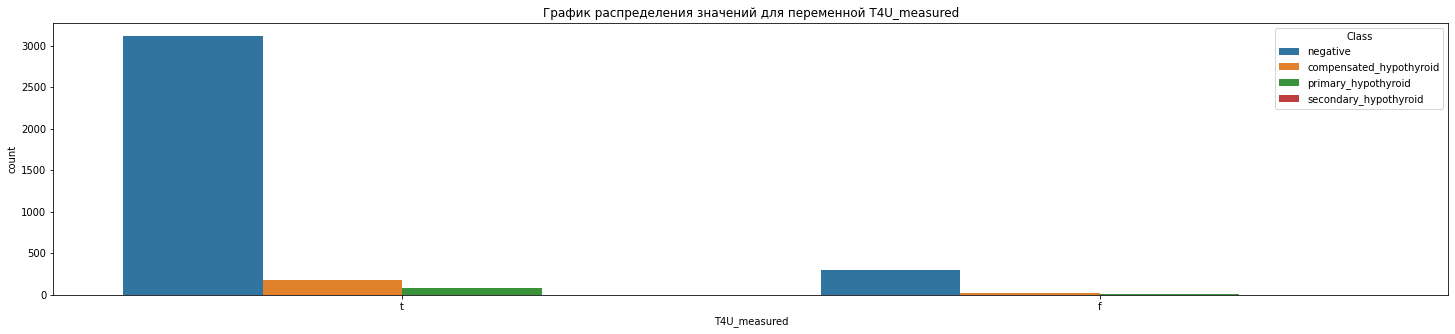

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class         compensated_hypothyroid  ...  secondary_hypothyroid
T4U_measured                           ...                       
f                                  17  ...                      1
t                                 177  ...                      1

[2 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Гипотеза H0 отклонена


Проведенный тест $\chi^2$ показал что признак 'T4U_measured' значим

In [ ]:
unsignificant_features.append(feature)

####Referral_source

In [ ]:
feature = 'referral_source'

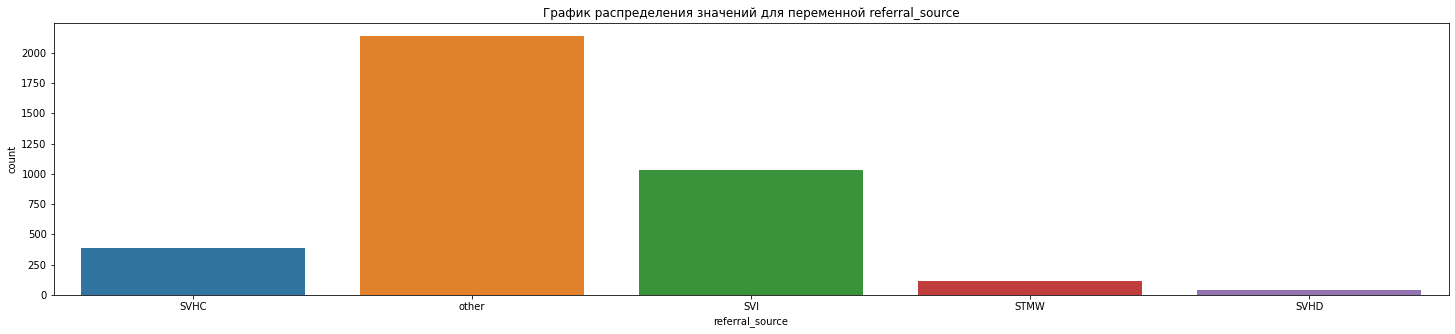

In [ ]:
plot_dist_categ(feature,data)

В выборке преобладают люди со значением признака 'goitre' равным False


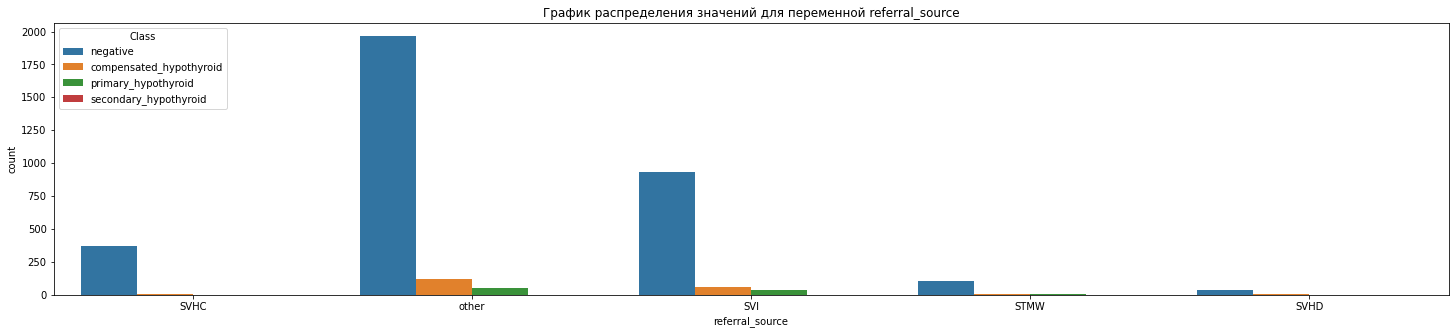

In [ ]:
plot_dist_categ(feature,data,'Class')

По графикам не наблюдается зависимости таргетов от данного признака. Проверим значимость признака

In [ ]:
categ_depend_test(feature,data_new)

Contingency tabel
Class            compensated_hypothyroid  ...  secondary_hypothyroid
referral_source                           ...                       
STMW                                   4  ...                      0
SVHC                                  10  ...                      0
SVHD                                   3  ...                      0
SVI                                   58  ...                      0
other                                119  ...                      2

[5 rows x 4 columns]
Гипотеза H0: переменные независимы
Гипотеза H1: пременные зависимы
Гипотеза H0 отклонена


Проведенный тест $\chi^2$ показал что признак 'Referral_source' значим, что странно посокльку этот признак обозначает только источник данных.

In [ ]:
unsignificant_features.append(feature)

##Multivariate analysis

###Pairplot

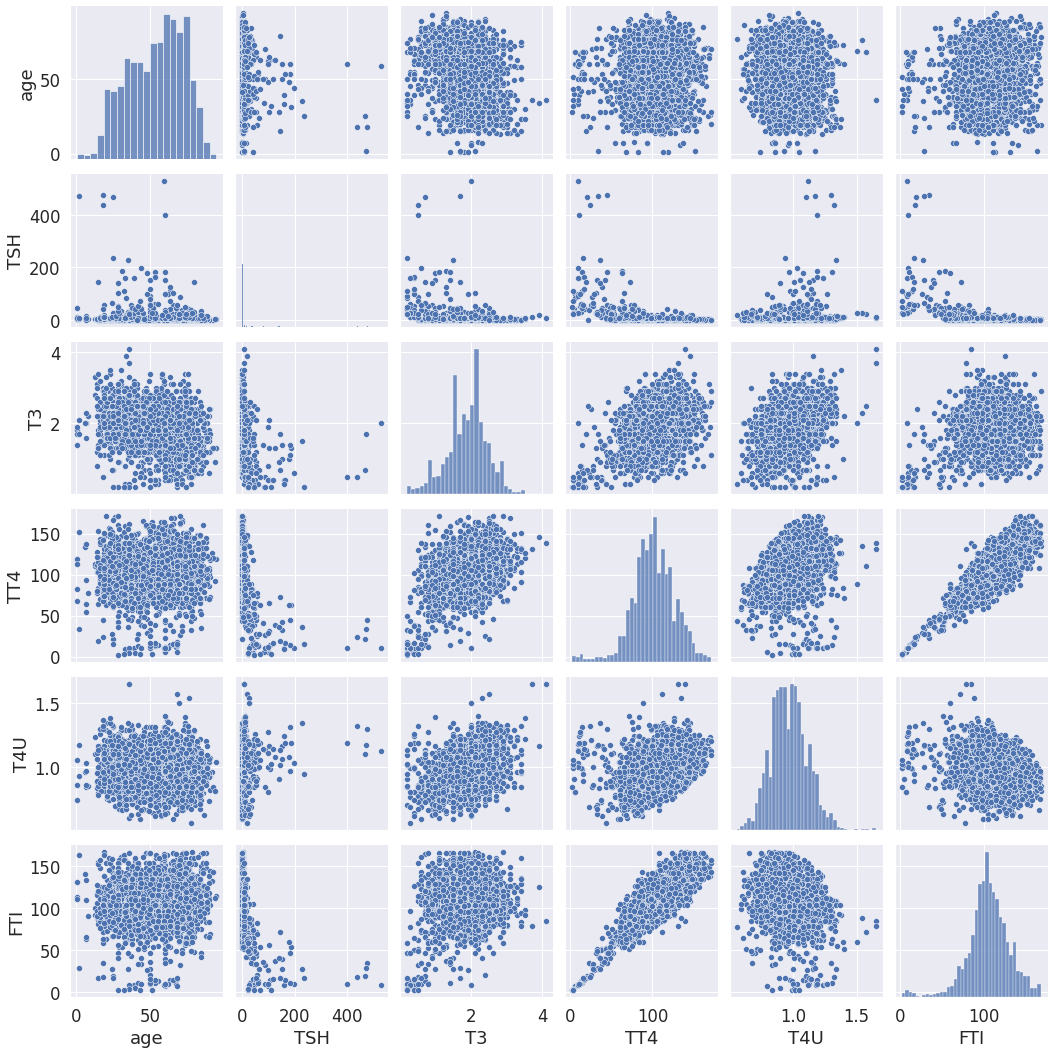

In [ ]:
sns.set(font_scale=1.5)
sns.pairplot(data=data_new)
plt.show()

Видно, что признаки слабо связаны между собой, но наблюдается связь между переменными 'TT4', 'FTI' и ' T3', убедимся в этом с помощью матриц корреляции.

##Correlation matrix##

Посмотрим на них с помощью heatmap

Начнем с коэффициентов Пирсона. Создадим heatmap который мы уже видели, когда использовали pandas_profiling

In [ ]:
corr_matrix_pearson_coef = data_new.corr()

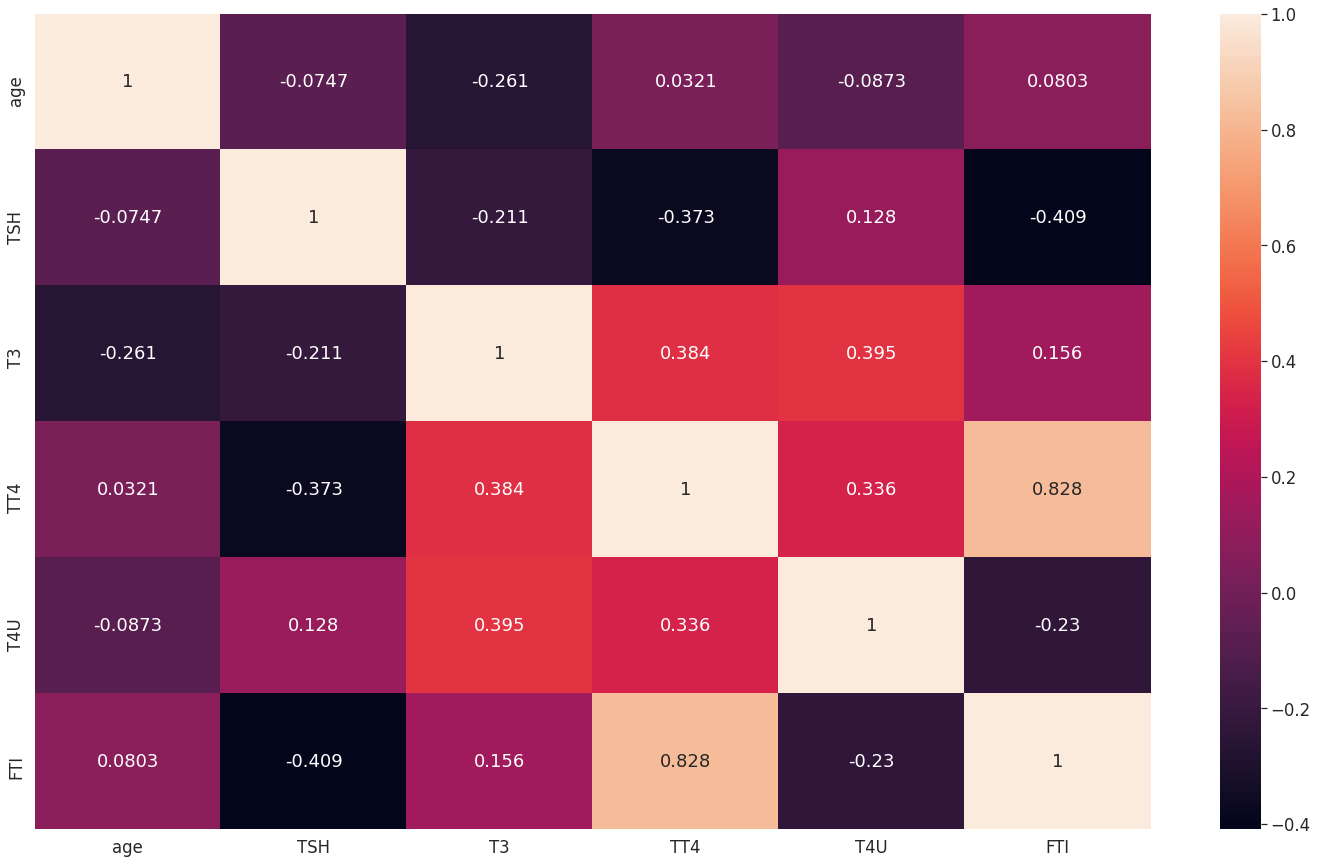

In [ ]:
plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix_pearson_coef, annot=True, fmt='.3g')
plt.show()

Видим, что имеется сильная линейная зависимость между 'TT4' и 'FTI', что не удивительно, поскольку в одном из источников говорится, что $FTI = TT4/T4U$ (https://www.cin.ufpe.br/~compint/aulas-IAS/programas/see5-demo/see5-win.html). Между переменными 'TT4','T3' и 'T4U' линейная связь намного слабее. Также заметим обратную связь пременной 'TSH' с переменными 'FTI' и 'TT4'. Проверим значимость коэффициентов.

In [ ]:
list_features1 = ['TT4','T4U','T3','FTI','TT4']
list_features2 = ['TT4','T4U','T3','FTI','TT4']
for feat1 in list_features1:
  for feat2 in list_features2:
    if feat1!=feat2:
      check_significance_pearson(data_new.dropna(),feat1,feat2)
  list_features2.remove(feat1)

Значение статистики = 0.33958582768838486, p-value=2.1678619333041045e-61
Коэффициент корреляции Пирсона между TT4 и T4U статистически значим
Значение статистики = 0.38041625847621363, p-value=8.223058195149043e-78
Коэффициент корреляции Пирсона между TT4 и T3 статистически значим
Значение статистики = 0.8281400196163113, p-value=0.0
Коэффициент корреляции Пирсона между TT4 и FTI статистически значим
Значение статистики = 0.3893741402369023, p-value=9.621668886839022e-82
Коэффициент корреляции Пирсона между T4U и T3 статистически значим
Значение статистики = -0.22621275419217332, p-value=2.6432032269835757e-27
Коэффициент корреляции Пирсона между T4U и FTI статистически значим
Значение статистики = 0.33958582768838486, p-value=2.1678619333041045e-61
Коэффициент корреляции Пирсона между T4U и TT4 статистически значим
Значение статистики = 0.16055134573985713, p-value=2.309498179765692e-14
Коэффициент корреляции Пирсона между T3 и FTI статистически значим
Значение статистики = 0.38041625

Получаем, что все коэффициенты между рассматриваемыми переменными оказались значимы.

Теперь посмотрим на матрицу коэффициентов Спирмана

In [ ]:
corr_matrix_spearman_coef = data_new.corr(method='spearman')

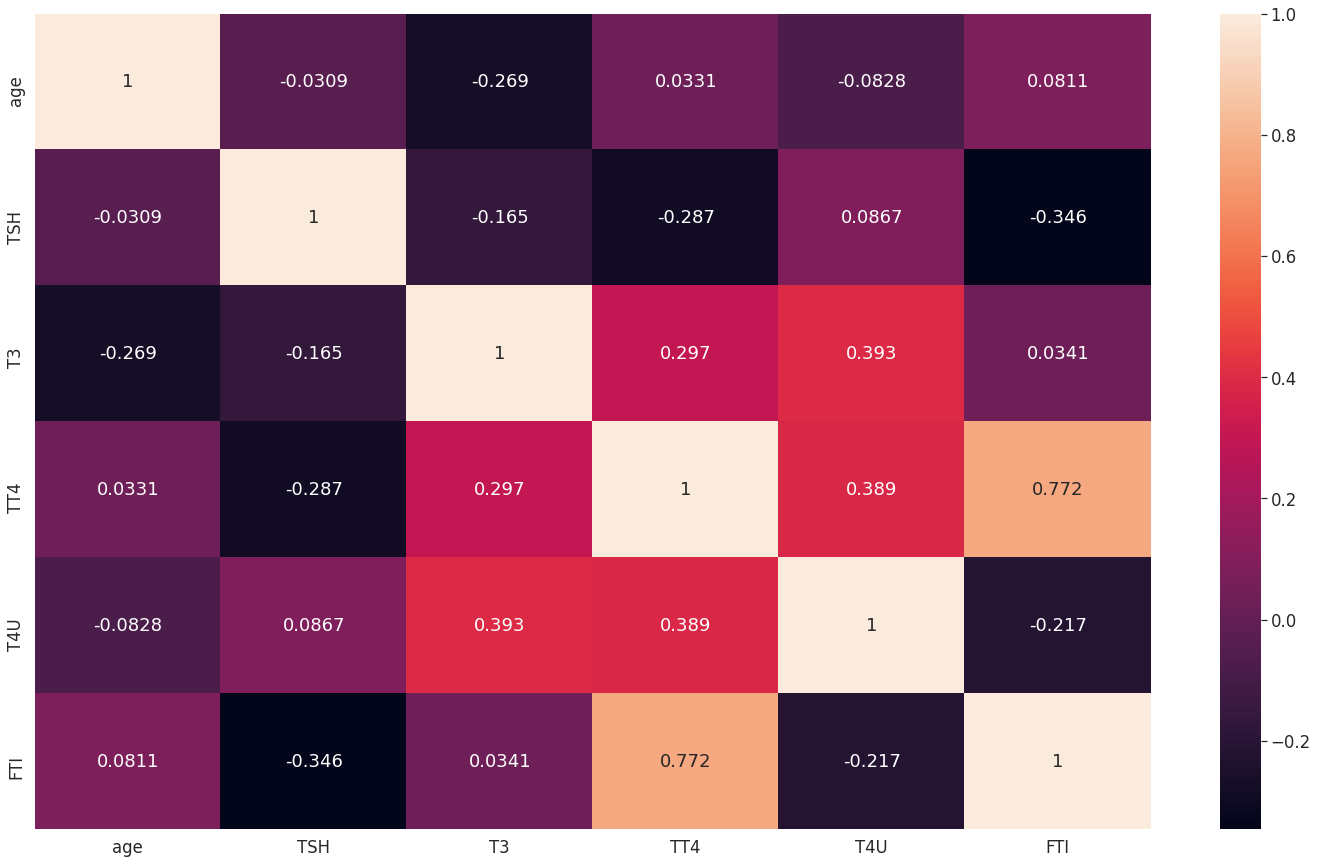

In [ ]:
plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix_spearman_coef, annot=True, fmt='.3g')
plt.show()

Выводы из представленной heatmap:


1.   Нелинейная связь сежду переменными 'TT4' и 'FTI' немного слабее, чем линейная.
2.   А между 'TT4','T4U' напротив, немного сильнее.

Проверим значимость коэффициентов Спирмана между этими переменными.





In [ ]:
list_features1 = ['TT4','T4U','T3','FTI','TT4']
list_features2 = ['TT4','T4U','T3','FTI','TT4']
for feat1 in list_features1:
  for feat2 in list_features2:
    if feat1!=feat2:
      check_significance_spearman(data_new.dropna(),feat1,feat2)
  list_features2.remove(feat1)

Значение статистики = 0.391017107520109, p-value=1.7730760404000094e-82
Коэффициент корреляции Спирмана между TT4 и T4U статистически значим
Значение статистики = 0.29698067552485036, p-value=1.05252531288087e-46
Коэффициент корреляции Спирмана между TT4 и T3 статистически значим
Значение статистики = 0.7732090418593097, p-value=0.0
Коэффициент корреляции Спирмана между TT4 и FTI статистически значим
Значение статистики = 0.3873927802864491, p-value=7.303052642899491e-81
Коэффициент корреляции Спирмана между T4U и T3 статистически значим
Значение статистики = -0.21367382278923844, p-value=1.7969235851493924e-24
Коэффициент корреляции Спирмана между T4U и FTI статистически значим
Значение статистики = 0.39101710752010893, p-value=1.7730760404001607e-82
Коэффициент корреляции Спирмана между T4U и TT4 статистически значим
Значение статистики = 0.04148195018843122, p-value=0.05000044140427994
Коэффициент корреляции Спирмана T3 и FTI статистически незначим
Значение статистики = 0.2969806755

Получаем, что все коэффициенты между рассматриваемыми переменными оказались значимы.

#Data preprocessing

##Dropping unimportant features

Во время EDA была исследована значимость признаков и хотя ни один из признаков не оказался значим, мы оставим их, ссылаясь на то, что из-за имбаланса классов, результаты тестов могут быть некорректными. А из категориальных уберем признак 'FTI' из-за его высокой корреляции с признаком 'TT4'.

In [ ]:
significant_features = unsignificant_features + numeric_features
significant_features.append('Class')
significant_features.remove('FTI')

In [ ]:
significant_features

['sex',
 'on_thyroxine',
 'query_hypothyroid',
 'psych',
 'TSH_measured',
 'T3_measured',
 'TT4_measured',
 'T4U_measured',
 'referral_source',
 'age',
 'TSH',
 'T3',
 'TT4',
 'T4U',
 'Class']

In [ ]:
data_wo_unimport = data_new[significant_features]

In [ ]:
data_wo_unimport

sex on_thyroxine query_hypothyroid  ...    TT4   T4U                  Class
0      F            f                 f  ...  125.0  1.14               negative
4      F            f                 f  ...   61.0  0.87               negative
7      F            f                 f  ...   80.0  0.70               negative
8      F            f                 f  ...  123.0  0.93               negative
9      M            f                 f  ...   83.0  0.89               negative
...   ..          ...               ...  ...    ...   ...                    ...
3669   F            f                 f  ...   28.0  1.00    primary_hypothyroid
3681   F            f                 f  ...   17.0  1.14    primary_hypothyroid
3689   M            f                 f  ...   15.0  0.89    primary_hypothyroid
1492   M            f                 t  ...   22.0   NaN  secondary_hypothyroid
2694   F            f                 f  ...   48.0  0.89  secondary_hypothyroid

[2385 rows x 15 columns]

##Handling missing values + Data normalization + Categorical encoding


Посмотрим на количество пропущенных значений в столбцах

In [ ]:
data_wo_unimport.isna().sum()

sex                  88
on_thyroxine          0
query_hypothyroid     0
psych                 0
TSH_measured          0
T3_measured           0
TT4_measured          0
T4U_measured          0
referral_source       0
age                   0
TSH                   0
T3                   46
TT4                   5
T4U                  25
Class                 0
dtype: int64

In [ ]:
TARGET = data_wo_unimport.Class
category_features_onehot = ['sex','refferal_source']
category_features_wo_onehot = ['on_thyroxine','query_hypothyroid','psych',
                               'TSH_measured','T3_measured','TT4_measured',
                               'T4U_measured',]
numeric_features = data_wo_unimport.select_dtypes(exclude=['object']).columns.tolist()
if 'sex' in category_features_wo_onehot:
    category_features_wo_onehot.remove('sex')
if 'refferal_source' in category_features_wo_onehot:
    category_features_wo_onehot.remove('refferal_source')
if 'Class' in category_features_wo_onehot:
    category_features_wo_onehot.remove('Class')

In [ ]:
data_wo_unimport.replace({"f": 0, "t": 1},inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
data_wo_unimport[category_features_wo_onehot] = data_wo_unimport[category_features_wo_onehot].astype('int')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
data_wo_unimport.drop('Class',axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Как показали тесты, признак 'sex' является значимым, поэтому заполним пропущенные значения метками 'unknown'. Остальные признаки с пропущенными значениями непрерывные, но у каждого из них уже есть индикатор-столбец пропущенных значений, поэтому просто заполним их медианами.

Как показал одномерный исследовательский анализ данных, численные признаки не подчинены нормальномую распределению, поэтому просто нормализуем их.

Поскольку признаки 'sex' и 'refferal_source' категориальные и без какого-либо упорядочения, то закодируем их с помощью OneHotEncoding.

In [ ]:
# Numerical
numerical_def = gen_features(
    columns=[[c] for c in numeric_features],
    classes=[
        {'class': SimpleImputer, 'strategy': 'median'},
        {'class': Normalizer}
    ]
)

category_def_wo_onehot = gen_features(
    columns=[[c] for c in category_features_wo_onehot]
)

# Sex and refferal_source
categorical_def = gen_features(
    columns=[['sex'],['referral_source']],
    classes=[
        {'class': SimpleImputer, 'strategy': 'constant', 'fill_value': 'Unknown'},
        {'class': OneHotEncoder, 'class': OneHotEncoder, 'handle_unknown': 'ignore'}
    ]    
)

In [ ]:
features = numerical_def + category_def_wo_onehot + categorical_def
mapper = DataFrameMapper(features)
len(features)

14

#Cross_validation

Поскольку в классах присутсвой высокий имбаланс, для кросс_валидации используем станданртный train_test_split, но с параметром stratify.

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(data_wo_unimport, TARGET, 
                                                  random_state=42, shuffle=True, test_size = 0.2, stratify = TARGET)
train_X_tr = pd.DataFrame(mapper.fit_transform(train_X))
val_X_tr = pd.DataFrame(mapper.transform(val_X))

#Logistic Regression

Поскольку мы имеем дело с мултиклассовой классификацией и у нас все также присутствует высокий имбаланс в данных, для измерения качества модели будем использовать микро метрики. Accuracy, logloss и AUC-ROC не подходят из-за бинарности, а обычные precision, recall и f1-score из-за имбаланса данных.

In [ ]:
model = LogisticRegression()
model.fit(train_X_tr, train_y)
print('\n\n======Multiclass prediction:======')
predictions = model.predict(val_X_tr)
print('Micro-averaged precision = {:.3f}'.format(precision_score(val_y,predictions, average = 'micro')))
print('Micro-averaged recall = {:.3f}'.format(recall_score(val_y,predictions, average = 'micro')))
print('Micro-averaged f1_score = {:.3f}'.format(f1_score(val_y,predictions, average = 'micro')))



======Multiclass prediction:======
Micro-averaged precision = 0.904
Micro-averaged recall = 0.904
Micro-averaged f1_score = 0.904


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Как видим, и точность и полнота и f-мера получились одинаковыми, что довольно странно, поскольку обычно метрики recall и precision противоположны друг другу. Построим матрицу неточностей. 

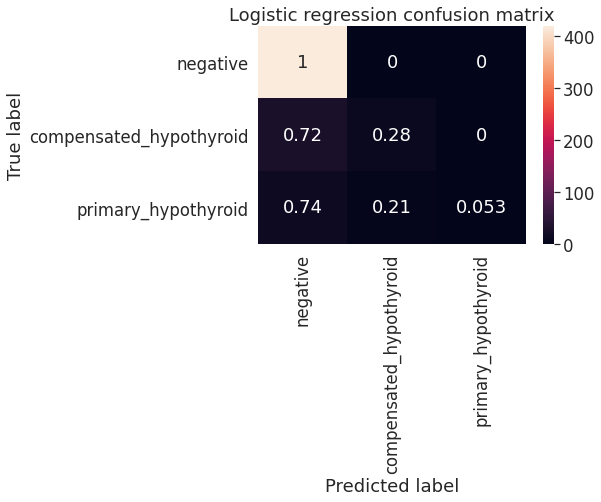

In [ ]:
conf = confusion_matrix(val_y, predictions, labels=val_y.unique())
sns.heatmap(conf,
            annot=conf/(np.sum(conf,axis=1).reshape((-1, 1))), #normalized by true class sizes
            yticklabels=val_y.unique(),
            xticklabels=val_y.unique());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

Как видим, классификатор абсолютно точно определяет класс 'negative', и имеет проблемы с определением остальных классов. Также заметим, что в тестовую выборку не попали элементы класса 'secondary_hypothyroid.

#Logistic Regression with regularization

In [ ]:
model = SGDClassifier(penalty="elasticnet",l1_ratio=1,alpha=0.001,class_weight='balanced')
model.fit(train_X_tr, train_y)
print('\n\n======Multiclass prediction:======')
predictions = model.predict(val_X_tr)
print('Micro-averaged precision = {:.3f}'.format(precision_score(val_y,predictions, average = 'micro')))
print('Micro-averaged recall = {:.3f}'.format(recall_score(val_y,predictions, average = 'micro')))
print('Micro-averaged f1_score = {:.3f}'.format(f1_score(val_y,predictions, average = 'micro')))



======Multiclass prediction:======
Micro-averaged precision = 0.881
Micro-averaged recall = 0.881
Micro-averaged f1_score = 0.881


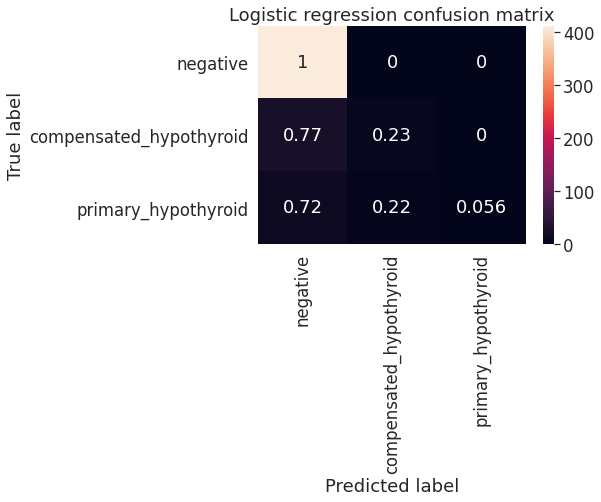

In [ ]:
conf = confusion_matrix(val_y, predictions, labels=val_y.unique())
sns.heatmap(conf,
            annot=conf/(np.sum(conf,axis=1).reshape((-1, 1))), #normalized by true class sizes
            yticklabels=val_y.unique(),
            xticklabels=val_y.unique());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

Добавление регуляризации ухудшило модель.

#K-nearest neighbours

In [ ]:
model = KNeighborsClassifier(3)
model.fit(train_X_tr, train_y)
print('\n\n======Multiclass prediction:======')
predictions = model.predict(val_X_tr)
print('Micro-averaged precision = {:.3f}'.format(precision_score(val_y,predictions, average = 'micro')))
print('Micro-averaged recall = {:.3f}'.format(recall_score(val_y,predictions, average = 'micro')))
print('Micro-averaged f1_score = {:.3f}'.format(f1_score(val_y,predictions, average = 'micro')))



======Multiclass prediction:======
Micro-averaged precision = 0.895
Micro-averaged recall = 0.895
Micro-averaged f1_score = 0.895


Как видим, и точность и полнота и f-мера снова получились одинаковыми, что еще более странно, поскольку обычно метрики recall и precision противоположны друг другу. Построим матрицу неточностей. 

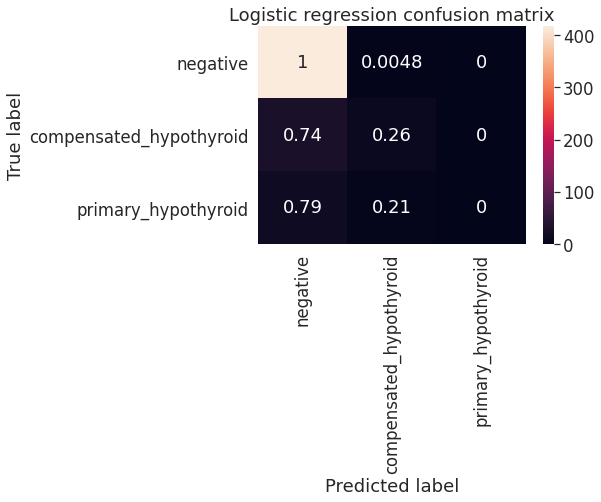

In [ ]:
conf = confusion_matrix(val_y, predictions,labels=val_y.unique())
sns.heatmap(conf,
            annot=conf/(np.sum(conf,axis=1).reshape((-1, 1))), #normalized by true class sizes
            yticklabels=val_y.unique(),
            xticklabels=val_y.unique());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

Как видим, классификатор уже намного хуже определяет класс 'campensated_hypothyroid', и также имеет большие проблемы с определением класса 'primary_hypothyroid', но класс 'negative' стал определяться намного лучше. Также заметно, что в тестовую выборку не попали элементы класса 'secondary_hypothyroid.

In [ ]:
params = {
    'n_neighbors': range(1,20),
    "metric" : ["euclidean", 'manhattan', "chebyshev",'minkowski'],
}
model = KNeighborsClassifier()
cv=StratifiedShuffleSplit(5)
Knnclassifier=GridSearchCV(model,params,scoring='precision_micro',cv=cv)
Knnclassifier.fit(train_X_tr,train_y)
# lasso_regressor.predict(val_X)
print(Knnclassifier.best_params_)
print(Knnclassifier.best_score_)


{'metric': 'chebyshev', 'n_neighbors': 5}
0.9005235602094241


In [ ]:
model = KNeighborsClassifier(6,metric='euclidean')
model.fit(train_X_tr, train_y)
print('\n\n======Multiclass prediction:======')
predictions = model.predict(val_X_tr)
print('Micro-averaged precision = {:.3f}'.format(precision_score(val_y,predictions, average = 'micro')))
print('Micro-averaged recall = {:.3f}'.format(recall_score(val_y,predictions, average = 'micro')))
print('Micro-averaged f1_score = {:.3f}'.format(f1_score(val_y,predictions, average = 'micro')))



======Multiclass prediction:======
Micro-averaged precision = 0.897
Micro-averaged recall = 0.897
Micro-averaged f1_score = 0.897


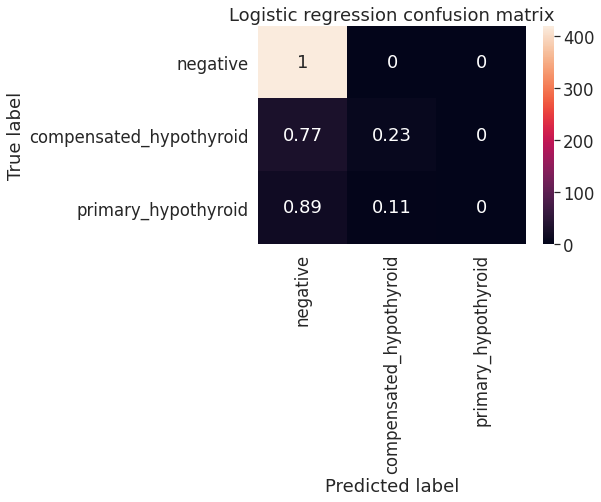

In [ ]:
conf = confusion_matrix(val_y, predictions,labels=val_y.unique())
sns.heatmap(conf,
            annot=conf/(np.sum(conf,axis=1).reshape((-1, 1))), #normalized by true class sizes
            yticklabels=val_y.unique(),
            xticklabels=val_y.unique());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

Тюнинг гиперпараметров позволил нам улучшить модель, но к сожалению только для предсказания класса 'negative'. То есть проблема с имбалансом классов все еще осталась((